#profgiri #pk #precog

# Task 0: The Biased Canvas

In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import copy
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
import random
import itertools

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [3]:
color_map = {
    0: [1.0, 0.0, 0.0],  # Red
    1: [0.0, 1.0, 0.0],  # Green
    2: [0.0, 0.0, 1.0],  # Blue
    3: [1.0, 1.0, 0.0],  # Yellow
    4: [1.0, 0.0, 1.0],  # Magenta
    5: [0.0, 1.0, 1.0],  # Cyan
    6: [1.0, 0.5, 0.0],  # Orange
    7: [0.5, 0.0, 1.0],  # Purple
    8: [0.5, 1.0, 0.0],  # Lime
    9: [1.0, 0.0, 0.5],  # Pink
}

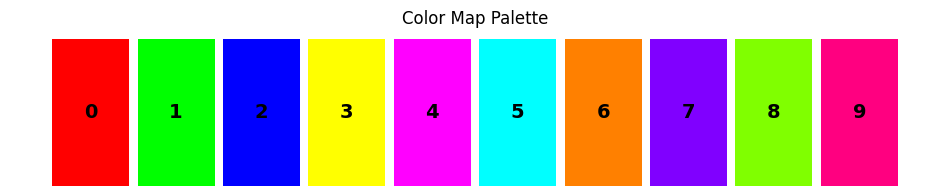

In [4]:
fig, ax = plt.subplots(figsize=(12, 2))
for digit, color in color_map.items():
    ax.bar(digit, 1, color=color, width=0.9)
    ax.text(digit, 0.5, str(digit), ha='center', va='center',
            fontsize=14, fontweight='bold', color='black')

ax.set_title("Color Map Palette")
ax.axis('off')
plt.show()

In [5]:
class ColoredMNIST(Dataset):
    def __init__(self, train=True):
        self.mnist = datasets.MNIST(root='./data', train=train, download=True)
        self.train = train

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img = transforms.ToTensor()(img)

        if self.train and np.random.rand() < 0.95:
            color_idx = label
        else:
            color_idx = np.random.randint(0, 10)
            while color_idx == label:
                color_idx = np.random.randint(0, 10)

        color = color_map[color_idx]

        grayscale_noise = 0.5 + 0.5 * torch.rand(1, 28, 28)
        background = grayscale_noise.repeat(3, 1, 1) * torch.tensor(color).view(3, 1, 1)

        mask = img.expand(3, -1, -1)
        colored_img = background * (1 - mask) + mask

        return colored_img, label

In [6]:
class RegularMNIST(Dataset):
    def __init__(self, train=True):
        self.mnist = datasets.MNIST(root='./data', train=train, download=True)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)

        return img, label

Label: 4


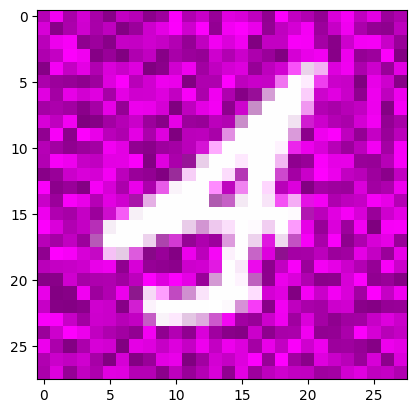

In [7]:
train_dataset = ColoredMNIST(train=True)
img, label = train_dataset[np.random.randint(len(train_dataset))]

print(f"Label: {label}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [8]:
class NanoNet(nn.Module):
    def __init__(self):
        super(NanoNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [9]:
model = NanoNet().to(device)

BATCH_SIZE = 2048
train_loader = torch.utils.data.DataLoader(ColoredMNIST(train=True), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(ColoredMNIST(train=False), batch_size=BATCH_SIZE, shuffle=False)

In [10]:
reg_train_loader = torch.utils.data.DataLoader(RegularMNIST(train=True), batch_size=BATCH_SIZE, shuffle=True)
reg_test_loader = torch.utils.data.DataLoader(RegularMNIST(train=False), batch_size=BATCH_SIZE, shuffle=False)

control_model = NanoNet().to(device)
control_optimizer = optim.Adam(control_model.parameters(), lr=0.01)
control_criterion = nn.CrossEntropyLoss()

print("Control: Regular MNIST with same settings")
print(f"Architecture: NanoNet | Batch Size: {BATCH_SIZE} | LR: 0.01 | Epochs: 3")
print(f"{'Epoch':<10} | {'Train Acc':<15} | {'Test Acc':<15}")

for epoch in range(3):
    control_model.train()
    correct = 0
    total = 0

    for images, labels in reg_train_loader:
        images, labels = images.to(device), labels.to(device)
        control_optimizer.zero_grad()
        outputs = control_model(images)
        loss = control_criterion(outputs, labels)
        loss.backward()
        control_optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    control_model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in reg_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = control_model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total

    print(f"{epoch+1:<10} | {train_acc:.2f}%{'':<13} | {test_acc:.2f}%")

print("-" * 60)
print(f"\nSame model, same training. Only difference is dataset bias.")
print(f"Regular MNIST generalizes fine, proving the model has enough capacity.")

Control: Regular MNIST with same settings
Architecture: NanoNet | Batch Size: 2048 | LR: 0.01 | Epochs: 3
Epoch      | Train Acc       | Test Acc       
1          | 61.09%              | 42.99%
2          | 92.75%              | 86.36%
3          | 95.97%              | 95.21%
------------------------------------------------------------

Same model, same training. Only difference is dataset bias.
Regular MNIST generalizes fine, proving the model has enough capacity.


# Task 1: The Cheater

Train a CNN on the biased colored MNIST dataset (95% color-digit correlation in training). The model should get high training accuracy but collapse on the test set where colors are randomized, proving it learned the color shortcut instead of digit shapes.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f"{'Epoch':<10} | {'Train Acc':<15} | {'Test Acc':<15}")

for epoch in range(3):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    print(f"{epoch+1:<10} | {train_acc:.2f}%{'':<13} | {test_acc:.2f}%")

print(f"\nTrain Accuracy: {train_acc:.2f}% (>95% requirement {'met' if train_acc >= 95 else 'FAILED'})")
print(f"Test Accuracy:  {test_acc:.2f}% (<20% requirement {'met' if test_acc < 20 else 'FAILED'})")


Epoch      | Train Acc       | Test Acc       
1          | 82.16%              | 0.94%
2          | 95.08%              | 0.82%
3          | 95.18%              | 3.23%

Train Accuracy: 95.18% (>95% requirement met)
Test Accuracy:  3.23% (<20% requirement met)


# Task 2: The Prober

Use activation maximization to visualize what the biased model has actually learned. We generate "dream" images that maximally activate class logits and individual conv filters, then quantify color vs shape selectivity across neurons. A deep dream experiment amplifies what the model sees in real images. If the model is color-biased, dreams should show colored textures rather than digit shapes, and amplification should enhance background color regions.

In [12]:
mnist_test = test_loader.dataset.mnist
digit_images = {}
for i in range(len(mnist_test)):
    img_pil, label = mnist_test[i]
    if label not in digit_images:
        digit_images[label] = transforms.ToTensor()(img_pil)
    if len(digit_images) == 10:
        break

color_names = ['RED', 'GREEN', 'BLUE', 'YELLOW', 'MAGENTA',
               'CYAN', 'ORANGE', 'PURPLE', 'LIME', 'PINK']

def make_bg_textured(img, color, seed=None):
    """Create a colored-MNIST image with textured background."""
    if seed is not None:
        torch.manual_seed(seed)
    grayscale_noise = 0.5 + 0.5 * torch.rand(1, 28, 28)
    background = grayscale_noise.repeat(3, 1, 1) * torch.tensor(color).view(3, 1, 1)
    mask = img.expand(3, -1, -1)
    return background * (1 - mask) + mask

def feature_dream(model, target_kind='class', target_idx=0, layer_name=None,
                  steps=300, lr=0.05):
    """
    Activation maximization with transformation robustness.

    target_kind: 'class' -> maximize class logit
                 'neuron' -> maximize spatial mean of a conv filter
                 'channel_max' -> maximize peak activation of a filter
    target_idx: class index (0-9) or filter index
    layer_name: conv layer name for neuron/channel_max modes
    """
    model.eval()

    img = torch.randn(1, 3, 28, 28, device=device) * 0.01 + 0.5
    img.requires_grad_(True)

    opt = torch.optim.Adam([img], lr=lr)
    stored = {}
    handle = None
    if target_kind in ('neuron', 'channel_max'):
        def hook(m, i, o): stored['a'] = o
        for name, mod in model.named_modules():
            if name == layer_name:
                handle = mod.register_forward_hook(hook)
                break

    for step in range(steps):
        opt.zero_grad()

        jx, jy = np.random.randint(-3, 4), np.random.randint(-3, 4)
        shifted = torch.roll(img, shifts=(jx, jy), dims=(2, 3))

        out = model(shifted)
        if target_kind == 'class':
            obj = -out[0, target_idx]
        elif target_kind == 'neuron':
            obj = -stored['a'][0, target_idx].mean()
        elif target_kind == 'channel_max':
            obj = -stored['a'][0, target_idx].max()

        tv = ((img[:,:,1:,:] - img[:,:,:-1,:])**2).mean() + \
             ((img[:,:,:,1:] - img[:,:,:,:-1])**2).mean()
        loss = obj + 0.01 * tv

        loss.backward()
        opt.step()

        with torch.no_grad():
            img.clamp_(0, 1)
            if step % 5 == 0 and step < steps - 20:
                img.data = F.avg_pool2d(
                    F.pad(img.data, (1,1,1,1), mode='reflect'),
                    kernel_size=3, stride=1
                )

    if handle: handle.remove()

    dreamed = img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    return np.clip(dreamed, 0, 1)

print("Task 2 helpers loaded")

Task 2 helpers loaded


Exp 1: Class dreams
  Class 0 done
  Class 1 done
  Class 2 done
  Class 3 done
  Class 4 done
  Class 5 done
  Class 6 done
  Class 7 done
  Class 8 done
  Class 9 done


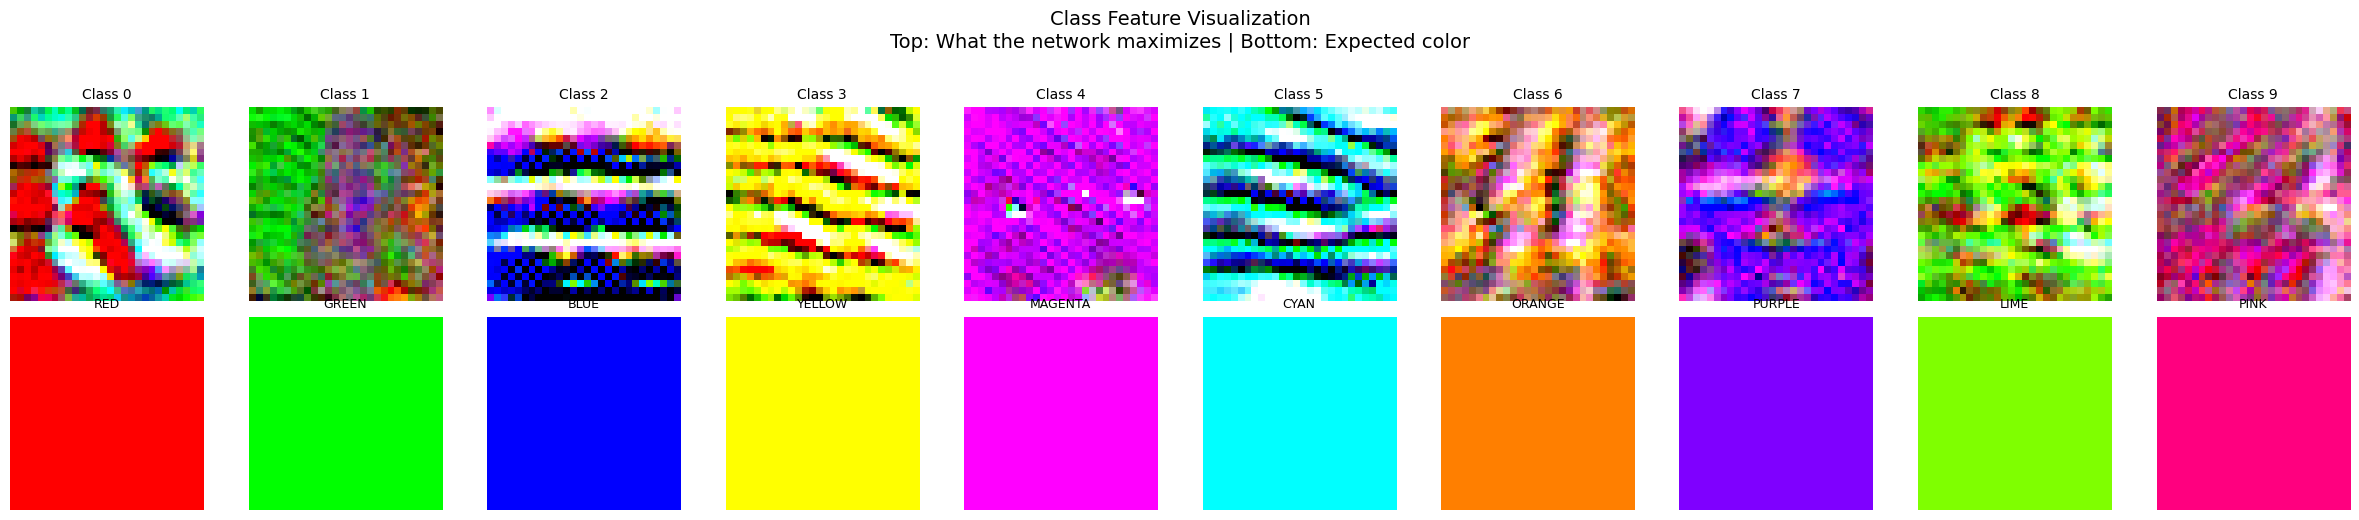


Color analysis:
 Class Expected        R      G      B   CosSim Match?  
     0 RED        0.552 0.495 0.364   0.668  partial
     1 GREEN      0.350 0.472 0.206   0.757  YES
     2 BLUE       0.409 0.383 0.567   0.711  YES
     3 YELLOW     0.818 0.755 0.180   0.986  YES
     4 MAGENTA    0.793 0.057 0.924   0.996  YES
     5 CYAN       0.233 0.641 0.684   0.970  YES
     6 ORANGE     0.797 0.520 0.317   0.942  YES
     7 PURPLE     0.492 0.138 0.807   0.986  YES
     8 LIME       0.523 0.758 0.148   0.978  YES
     9 PINK       0.732 0.267 0.490   0.949  YES

  9/10 classes dream their expected color -> model is COLOR-BIASED

Exp 2: Neuron dreams (conv1 -> conv2 -> conv3)
  conv1 done (8 filters)
  conv2 done (8 filters)
  conv3 done (8 filters)


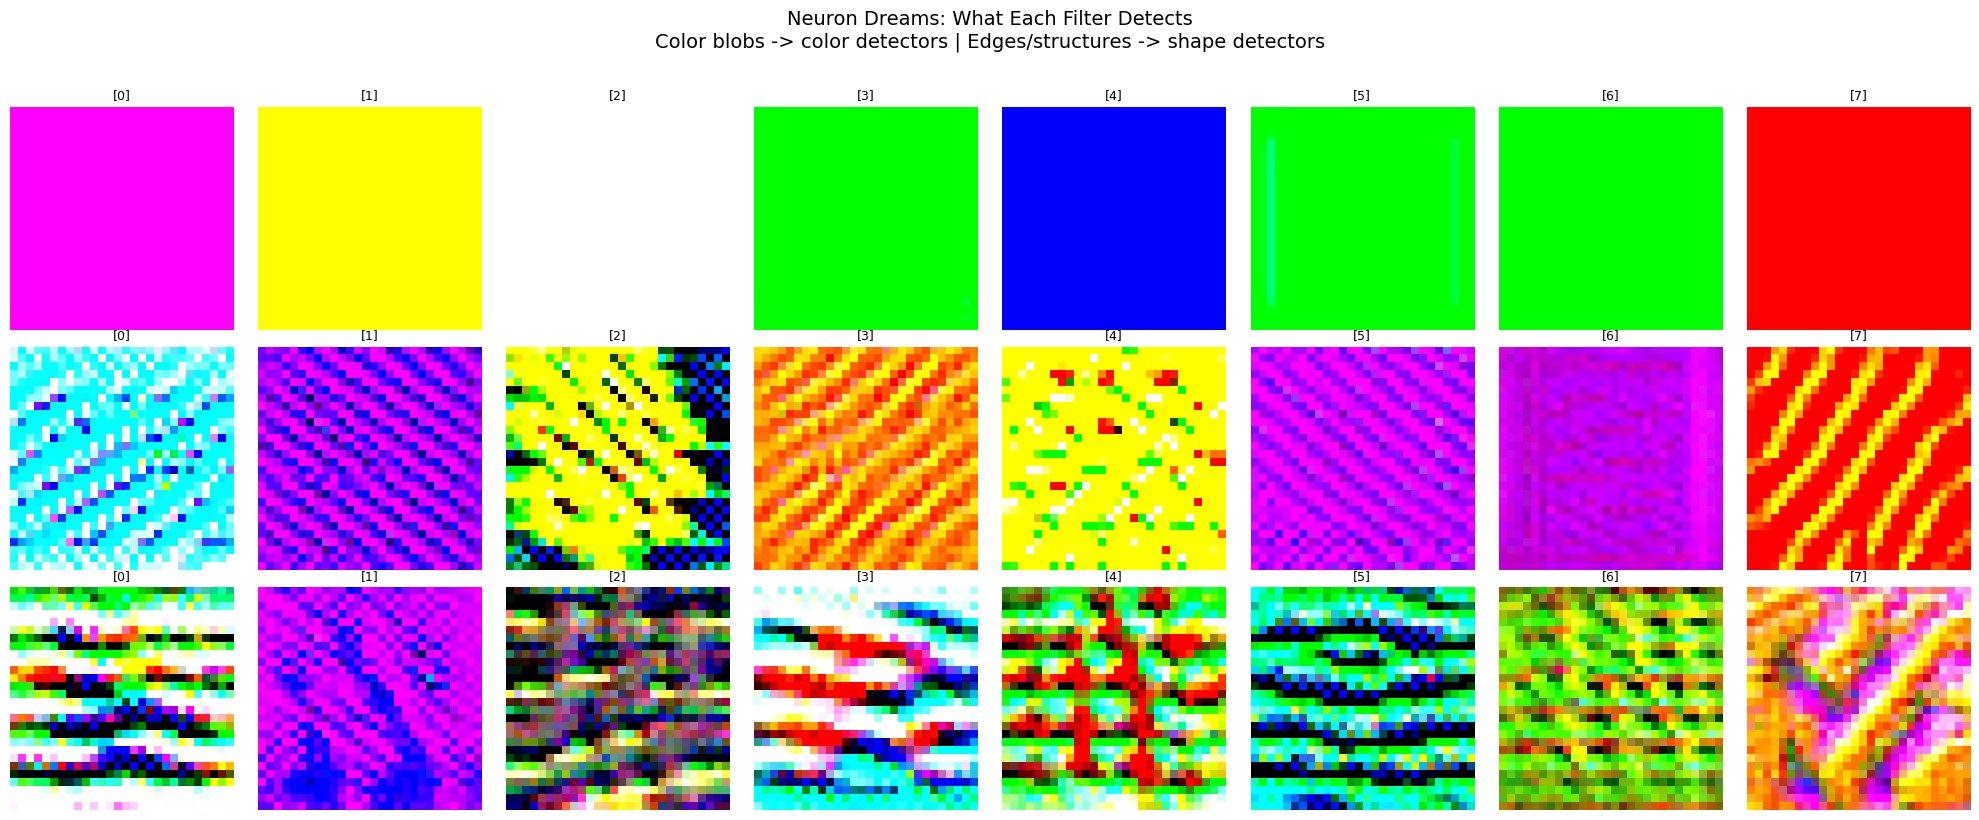


Exp 3: Polysemanticity analysis (conv3)
 Neuron Type              Color Var  Shape Var  #Active Peak Trigger        
      0 POLYSEMANTIC (broad)     0.2797     0.1375       34 d=3, YELLOW         
      1 COLOR                0.3955     0.0038       22 d=1, MAGENTA        
      2 COLOR (broad)        0.2489     0.0101       40 d=1, ORANGE         
      3 POLYSEMANTIC         0.0841     0.0583       23 d=8, CYAN           
      4 COLOR (broad)        0.1973     0.0294       32 d=3, LIME           
      5 COLOR                0.6062     0.0032       27 d=1, GREEN          
      6 COLOR                0.1893     0.0029       18 d=1, LIME           
      7 COLOR (broad)        0.3643     0.0013       31 d=6, ORANGE         
      8 COLOR                0.1891     0.0605       26 d=5, BLUE           
      9 POLYSEMANTIC (broad)     0.0725     0.0521       33 d=8, YELLOW         
     10 COLOR                0.2824     0.0397       27 d=3, PINK           
     11 COLOR (broad)      

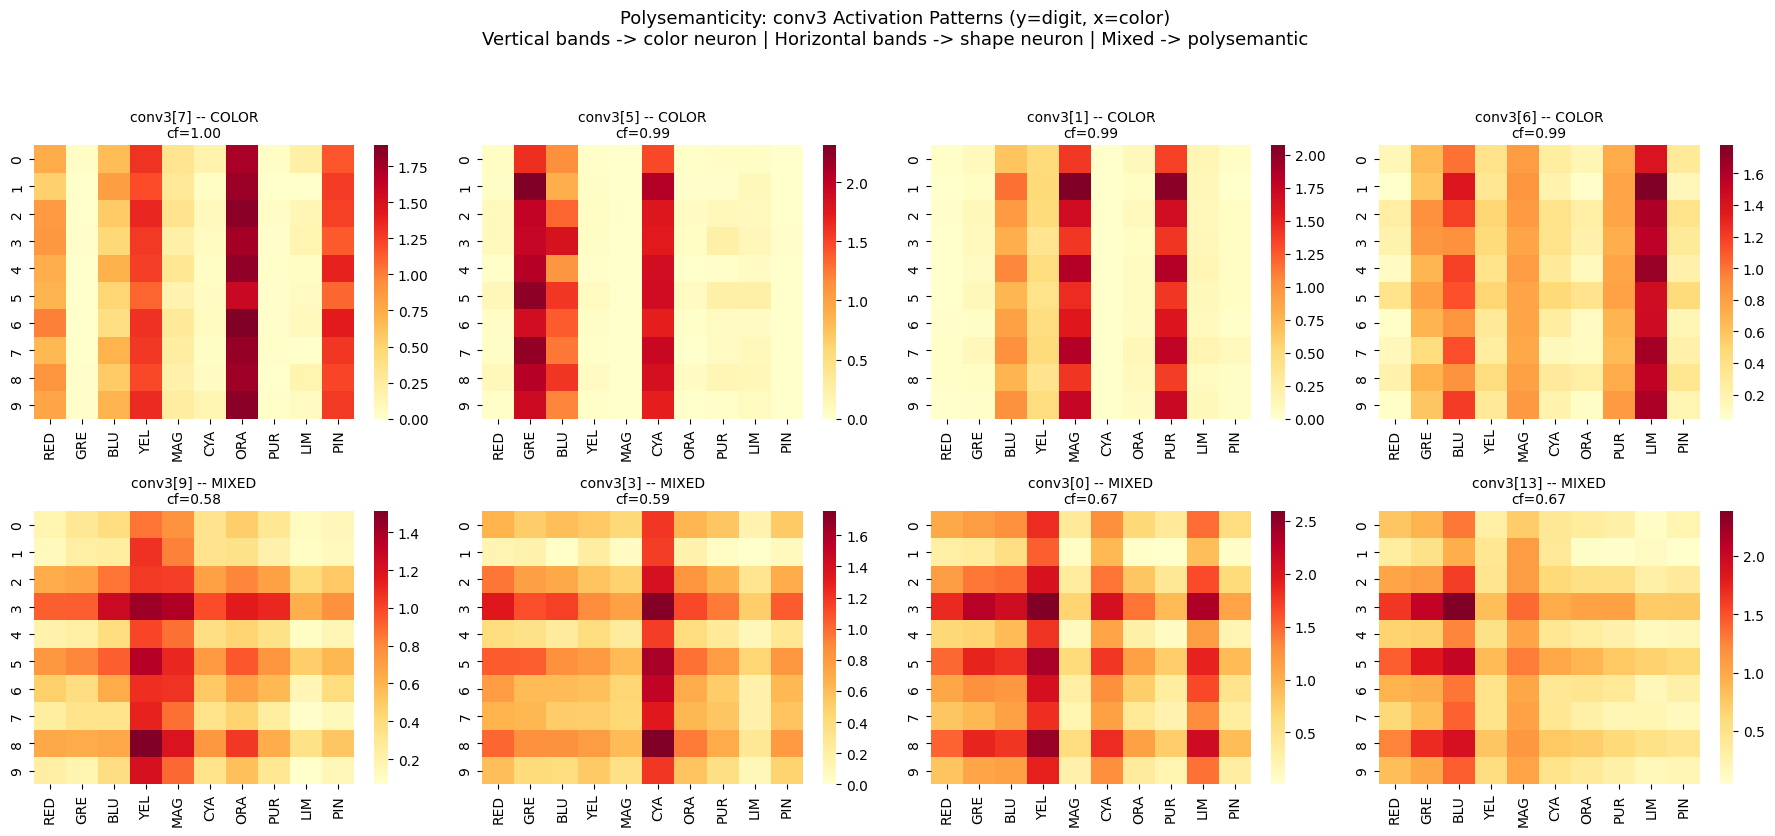


Exp 4: Deep dream on real images


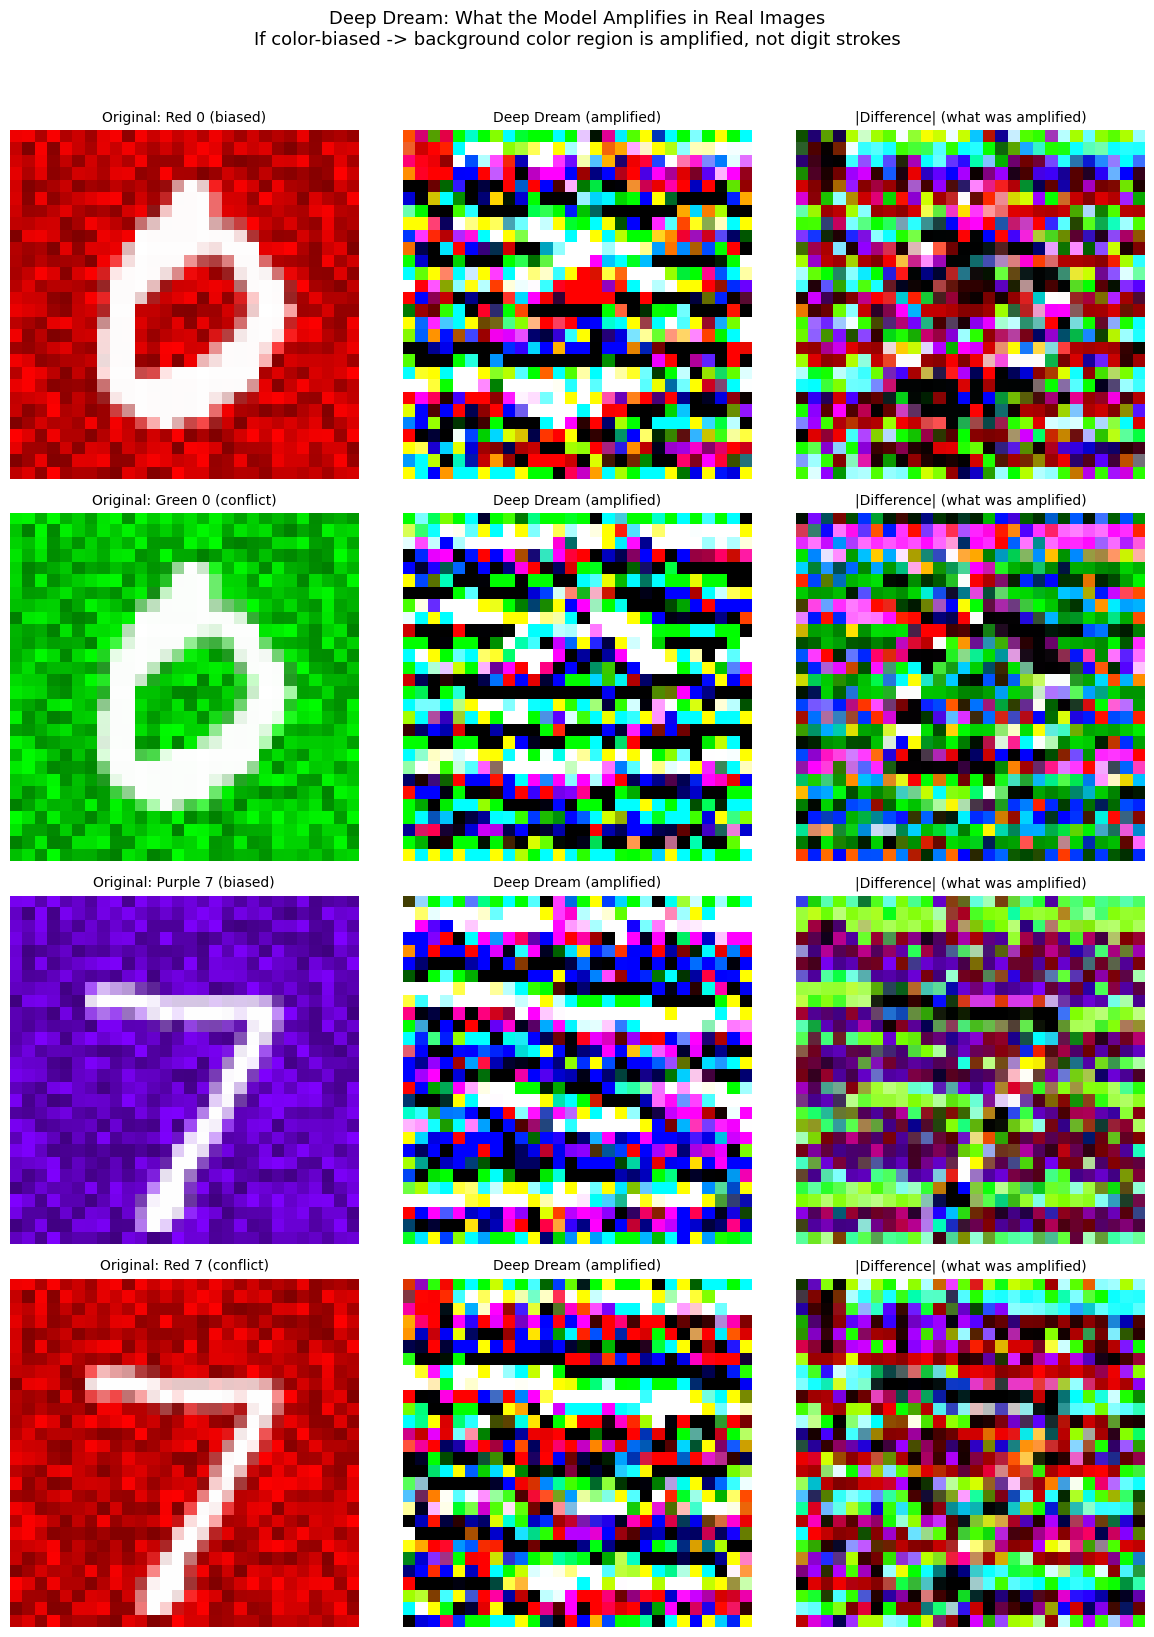


Summary: 9/10 dream colors, 12 color neurons, 0 shape neurons, 4 polysemantic


In [13]:

print("Exp 1: Class dreams")

class_dreams = {}
for c in range(10):
    class_dreams[c] = feature_dream(model, 'class', c, steps=300)
    print(f"  Class {c} done")

fig, axes = plt.subplots(2, 10, figsize=(24, 5))
for c in range(10):
    axes[0, c].imshow(class_dreams[c])
    axes[0, c].set_title(f"Class {c}", fontsize=10)
    axes[0, c].axis('off')
    swatch = np.ones((28, 28, 3)) * np.array(color_map[c])
    axes[1, c].imshow(swatch)
    axes[1, c].set_title(f"{color_names[c]}", fontsize=9)
    axes[1, c].axis('off')

axes[0, 0].set_ylabel("Model's\nDream", fontsize=11, fontweight='bold', rotation=0, labelpad=50)
axes[1, 0].set_ylabel("Expected\nColor", fontsize=11, fontweight='bold', rotation=0, labelpad=50)
plt.suptitle("Class Feature Visualization\n"
             "Top: What the network maximizes | Bottom: Expected color",
             fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

print("\nColor analysis:")
print(f"{'Class':>6} {'Expected':<10} {'R':>6} {'G':>6} {'B':>6} {'CosSim':>8} {'Match?':<8}")
matches = 0
for c in range(10):
    dream = class_dreams[c]
    mean_rgb = dream.mean(axis=(0, 1))
    expected = np.array(color_map[c])
    cos_sim = np.dot(mean_rgb, expected) / (np.linalg.norm(mean_rgb) * np.linalg.norm(expected) + 1e-8)
    match = "YES" if cos_sim > 0.7 else "partial" if cos_sim > 0.4 else "no"
    if cos_sim > 0.7: matches += 1
    print(f"  {c:>4} {color_names[c]:<10} {mean_rgb[0]:>5.3f} {mean_rgb[1]:>5.3f} {mean_rgb[2]:>5.3f} {cos_sim:>7.3f}  {match}")
print(f"\n  {matches}/10 classes dream their expected color -> model is {'COLOR-BIASED' if matches >= 6 else 'MIXED'}")

print("\nExp 2: Neuron dreams (conv1 -> conv2 -> conv3)")

layers_info = [('conv1', 8), ('conv2', 16), ('conv3', 16)]
fig, axes = plt.subplots(3, 8, figsize=(20, 8))

for row, (lname, n_filt) in enumerate(layers_info):
    n_show = min(8, n_filt)
    for fi in range(n_show):
        nimg = feature_dream(model, 'neuron', fi, layer_name=lname, steps=200)
        axes[row, fi].imshow(nimg)
        axes[row, fi].set_title(f"[{fi}]", fontsize=9)
        axes[row, fi].axis('off')
    for fi in range(n_show, 8):
        axes[row, fi].axis('off')
    axes[row, 0].set_ylabel(lname, fontsize=12, fontweight='bold', rotation=0, labelpad=40)
    print(f"  {lname} done ({n_show} filters)")

plt.suptitle("Neuron Dreams: What Each Filter Detects\n"
             "Color blobs -> color detectors | Edges/structures -> shape detectors",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nExp 3: Polysemanticity analysis (conv3)")

model.eval()
n_conv3 = 16
neuron_response = np.zeros((n_conv3, 10, 10))

for d in range(10):
    for c in range(10):
        test_img = make_bg_textured(digit_images[d], color_map[c], seed=42)
        act_store = {}
        def _hook(m, i, o, s=act_store): s['a'] = o.detach()
        h = model.bn3.register_forward_hook(_hook)
        with torch.no_grad():
            _ = model(test_img.unsqueeze(0).to(device))
        h.remove()
        post_relu = F.relu(act_store['a'])
        for fi in range(n_conv3):
            neuron_response[fi, d, c] = post_relu[0, fi].mean().item()

print(f"{'Neuron':>7} {'Type':<16} {'Color Var':>10} {'Shape Var':>10} {'#Active':>8} {'Peak Trigger':<20}")

color_fracs = []
for fi in range(n_conv3):
    acts = neuron_response[fi]
    cv = acts.mean(axis=0).var()
    sv = acts.mean(axis=1).var()
    cf = cv / (cv + sv + 1e-8)
    color_fracs.append(cf)

    max_idx = np.unravel_index(acts.argmax(), acts.shape)
    trigger = f"d={max_idx[0]}, {color_names[max_idx[1]]}"
    n_active = (acts > acts.max() * 0.5).sum()

    if cf > 0.7:
        ntype = "COLOR"
    elif cf < 0.3:
        ntype = "SHAPE"
    else:
        ntype = "POLYSEMANTIC"
    if n_active > 30:
        ntype += " (broad)"

    print(f"  {fi:>5} {ntype:<16} {cv:>10.4f} {sv:>10.4f} {n_active:>8} {trigger:<20}")

n_color = sum(1 for cf in color_fracs if cf > 0.7)
n_shape = sum(1 for cf in color_fracs if cf < 0.3)
n_poly = n_conv3 - n_color - n_shape
print(f"\n  Summary: {n_color} color, {n_shape} shape, {n_poly} polysemantic out of {n_conv3}")

sorted_idx = np.argsort(color_fracs)[::-1]
top_color = sorted_idx[:4]
top_other = sorted_idx[-4:][::-1]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for ci, fi in enumerate(top_color):
    sns.heatmap(neuron_response[fi], ax=axes[0, ci], cmap='YlOrRd',
                xticklabels=[cn[:3] for cn in color_names],
                yticklabels=range(10), cbar=True, annot=False)
    axes[0, ci].set_title(f"conv3[{fi}] -- COLOR\ncf={color_fracs[fi]:.2f}", fontsize=10)

for ci, fi in enumerate(top_other):
    tag = "SHAPE" if color_fracs[fi] < 0.3 else "MIXED"
    sns.heatmap(neuron_response[fi], ax=axes[1, ci], cmap='YlOrRd',
                xticklabels=[cn[:3] for cn in color_names],
                yticklabels=range(10), cbar=True, annot=False)
    axes[1, ci].set_title(f"conv3[{fi}] -- {tag}\ncf={color_fracs[fi]:.2f}", fontsize=10)

plt.suptitle("Polysemanticity: conv3 Activation Patterns (y=digit, x=color)\n"
             "Vertical bands -> color neuron | Horizontal bands -> shape neuron | Mixed -> polysemantic",
             fontsize=13, y=1.04)
plt.tight_layout()
plt.show()

print("\nExp 4: Deep dream on real images")

stored = {}

def deep_dream(model, start_img, target_layer_name, steps=100, lr=0.02):
    """Amplify features the network already detects in a real image."""
    model.eval()
    img = start_img.clone().unsqueeze(0).to(device)
    img.requires_grad_(True)
    opt = torch.optim.Adam([img], lr=lr)

    def hook(m, i, o): stored['a'] = o
    for name, mod in model.named_modules():
        if name == target_layer_name:
            h = mod.register_forward_hook(hook)
            break

    for step in range(steps):
        opt.zero_grad()
        _ = model(img)
        loss = -stored['a'].norm()
        loss.backward()
        opt.step()
        with torch.no_grad():
            img.clamp_(0, 1)

    h.remove()
    return img.detach().cpu().squeeze().permute(1, 2, 0).numpy().clip(0, 1)

demo_pairs = [
    (0, 0, "Red 0 (biased)"),
    (0, 1, "Green 0 (conflict)"),
    (7, 7, "Purple 7 (biased)"),
    (7, 0, "Red 7 (conflict)"),
]

fig, axes = plt.subplots(len(demo_pairs), 3, figsize=(12, 4*len(demo_pairs)))
for row, (digit, cidx, desc) in enumerate(demo_pairs):
    real_img = make_bg_textured(digit_images[digit], color_map[cidx], seed=42)
    dreamed = deep_dream(model, real_img, 'conv3', steps=80, lr=0.02)
    orig_np = np.clip(real_img.permute(1, 2, 0).numpy(), 0, 1)
    diff = np.abs(dreamed - orig_np)
    diff = diff / (diff.max() + 1e-8)

    axes[row, 0].imshow(orig_np)
    axes[row, 0].set_title(f"Original: {desc}", fontsize=10)
    axes[row, 0].axis('off')
    axes[row, 1].imshow(dreamed)
    axes[row, 1].set_title("Deep Dream (amplified)", fontsize=10)
    axes[row, 1].axis('off')
    axes[row, 2].imshow(diff)
    axes[row, 2].set_title("|Difference| (what was amplified)", fontsize=10)
    axes[row, 2].axis('off')

plt.suptitle("Deep Dream: What the Model Amplifies in Real Images\n"
             "If color-biased -> background color region is amplified, not digit strokes",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nSummary: {matches}/10 dream colors, {n_color} color neurons, {n_shape} shape neurons, {n_poly} polysemantic")

# Task 4: The Intervention

Train a model that ignores background color and classifies by digit shape alone, using the same biased dataset. After trying WeightedRandomSampler and Mixup variants without success, the winning approach combines strong ColorJitter (hue=0.5, randomly rotating colors each epoch) with random RGB channel permutation per batch. Together these prevent the model from latching onto any fixed color-digit mapping.

In [15]:

robust_model = NanoNet().to(device)
robust_optimizer = optim.Adam(robust_model.parameters(), lr=0.001)
robust_scheduler = optim.lr_scheduler.CosineAnnealingLR(robust_optimizer, T_max=15)
robust_criterion = nn.CrossEntropyLoss()

# color augmentation: strong jitter + random channel permutation
jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.5)
ALL_PERMS = list(itertools.permutations([0, 1, 2]))

ROBUST_BATCH = 256
robust_train_loader = DataLoader(train_dataset, batch_size=ROBUST_BATCH, shuffle=True)

print(f"Task 4: Robust retraining | batch={ROBUST_BATCH} | 10 epochs")

best_test_acc = 0
for epoch in range(10):
    robust_model.train()
    correct, total = 0, 0

    for images, labels in robust_train_loader:
        images, labels = images.to(device), labels.to(device)
        images = jitter(images)
        perm = list(random.choice(ALL_PERMS))
        images = images[:, perm, :, :]

        robust_optimizer.zero_grad()
        outputs = robust_model(images)
        loss = robust_criterion(outputs, labels)
        loss.backward()
        robust_optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    robust_scheduler.step()
    train_acc = 100 * correct / total

    robust_model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = robust_model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    best_test_acc = max(best_test_acc, test_acc)
    lr_now = robust_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1:2d}: Train {train_acc:.1f}% | Hard Test {test_acc:.2f}% | Best {best_test_acc:.2f}% | LR {lr_now:.5f}")

print(f"\nBest hard test accuracy: {best_test_acc:.1f}%")

Task 4: Robust retraining | batch=256 | 10 epochs
Epoch  1: Train 32.4% | Hard Test 48.57% | Best 48.57% | LR 0.00099
Epoch  2: Train 69.5% | Hard Test 71.29% | Best 71.29% | LR 0.00096
Epoch  3: Train 85.6% | Hard Test 83.87% | Best 83.87% | LR 0.00090
Epoch  4: Train 91.0% | Hard Test 91.32% | Best 91.32% | LR 0.00083
Epoch  5: Train 93.1% | Hard Test 89.65% | Best 91.32% | LR 0.00075
Epoch  6: Train 94.4% | Hard Test 93.89% | Best 93.89% | LR 0.00065
Epoch  7: Train 95.1% | Hard Test 93.78% | Best 93.89% | LR 0.00055
Epoch  8: Train 95.6% | Hard Test 93.09% | Best 93.89% | LR 0.00045
Epoch  9: Train 96.0% | Hard Test 93.90% | Best 93.90% | LR 0.00035
Epoch 10: Train 96.3% | Hard Test 93.28% | Best 93.90% | LR 0.00025

Best hard test accuracy: 93.9%


In [16]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        self.fwd_hook = target_layer.register_forward_hook(self._save_activations)
        self.bwd_hook = target_layer.register_full_backward_hook(self._save_gradients)

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def _save_activations(self, module, input, output):
        self.activations = output

    def remove_hooks(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

    def generate_heatmap(self, input_image, class_idx=None):
        self.model.eval()
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()

        activations = F.relu(self.activations)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam.detach().cpu().numpy()[0, 0, :, :]
        cam = cv2.resize(cam, (input_image.shape[3], input_image.shape[2]))

        if np.max(cam) - np.min(cam) != 0:
            cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

        return cam, class_idx, output

print("GradCAM ready")

GradCAM ready


Avg BG focus -- Lazy: 48.3% | Robust: 41.2%

Color-swap litmus test: all digits colored RED
  Red 0 -> Lazy: 0 (98%) [COLOR]  |  Robust: 0 (95%) [SHAPE]
  Red 1 -> Lazy: 0 (47%) [COLOR]  |  Robust: 1 (98%) [SHAPE]
  Red 2 -> Lazy: 0 (84%) [COLOR]  |  Robust: 2 (92%) [SHAPE]
  Red 3 -> Lazy: 0 (78%) [COLOR]  |  Robust: 8 (52%) [???]
  Red 4 -> Lazy: 0 (83%) [COLOR]  |  Robust: 4 (100%) [SHAPE]
  Red 5 -> Lazy: 0 (86%) [COLOR]  |  Robust: 5 (70%) [SHAPE]
  Red 6 -> Lazy: 0 (90%) [COLOR]  |  Robust: 6 (99%) [SHAPE]
  Red 7 -> Lazy: 0 (74%) [COLOR]  |  Robust: 7 (100%) [SHAPE]
  Red 8 -> Lazy: 0 (87%) [COLOR]  |  Robust: 8 (95%) [SHAPE]
  Red 9 -> Lazy: 0 (83%) [COLOR]  |  Robust: 9 (36%) [SHAPE]

Lazy follows COLOR: 10/10
Robust follows SHAPE: 9/10

10x10 prediction grid (robust model)
             RED   GREEN    BLUE  YELLOW MAGENTA    CYAN  ORANGE  PURPLE    LIME    PINK
Digit 0:      0       0       0       0       0       0       0       0       0       0  
Digit 1:      1       1    

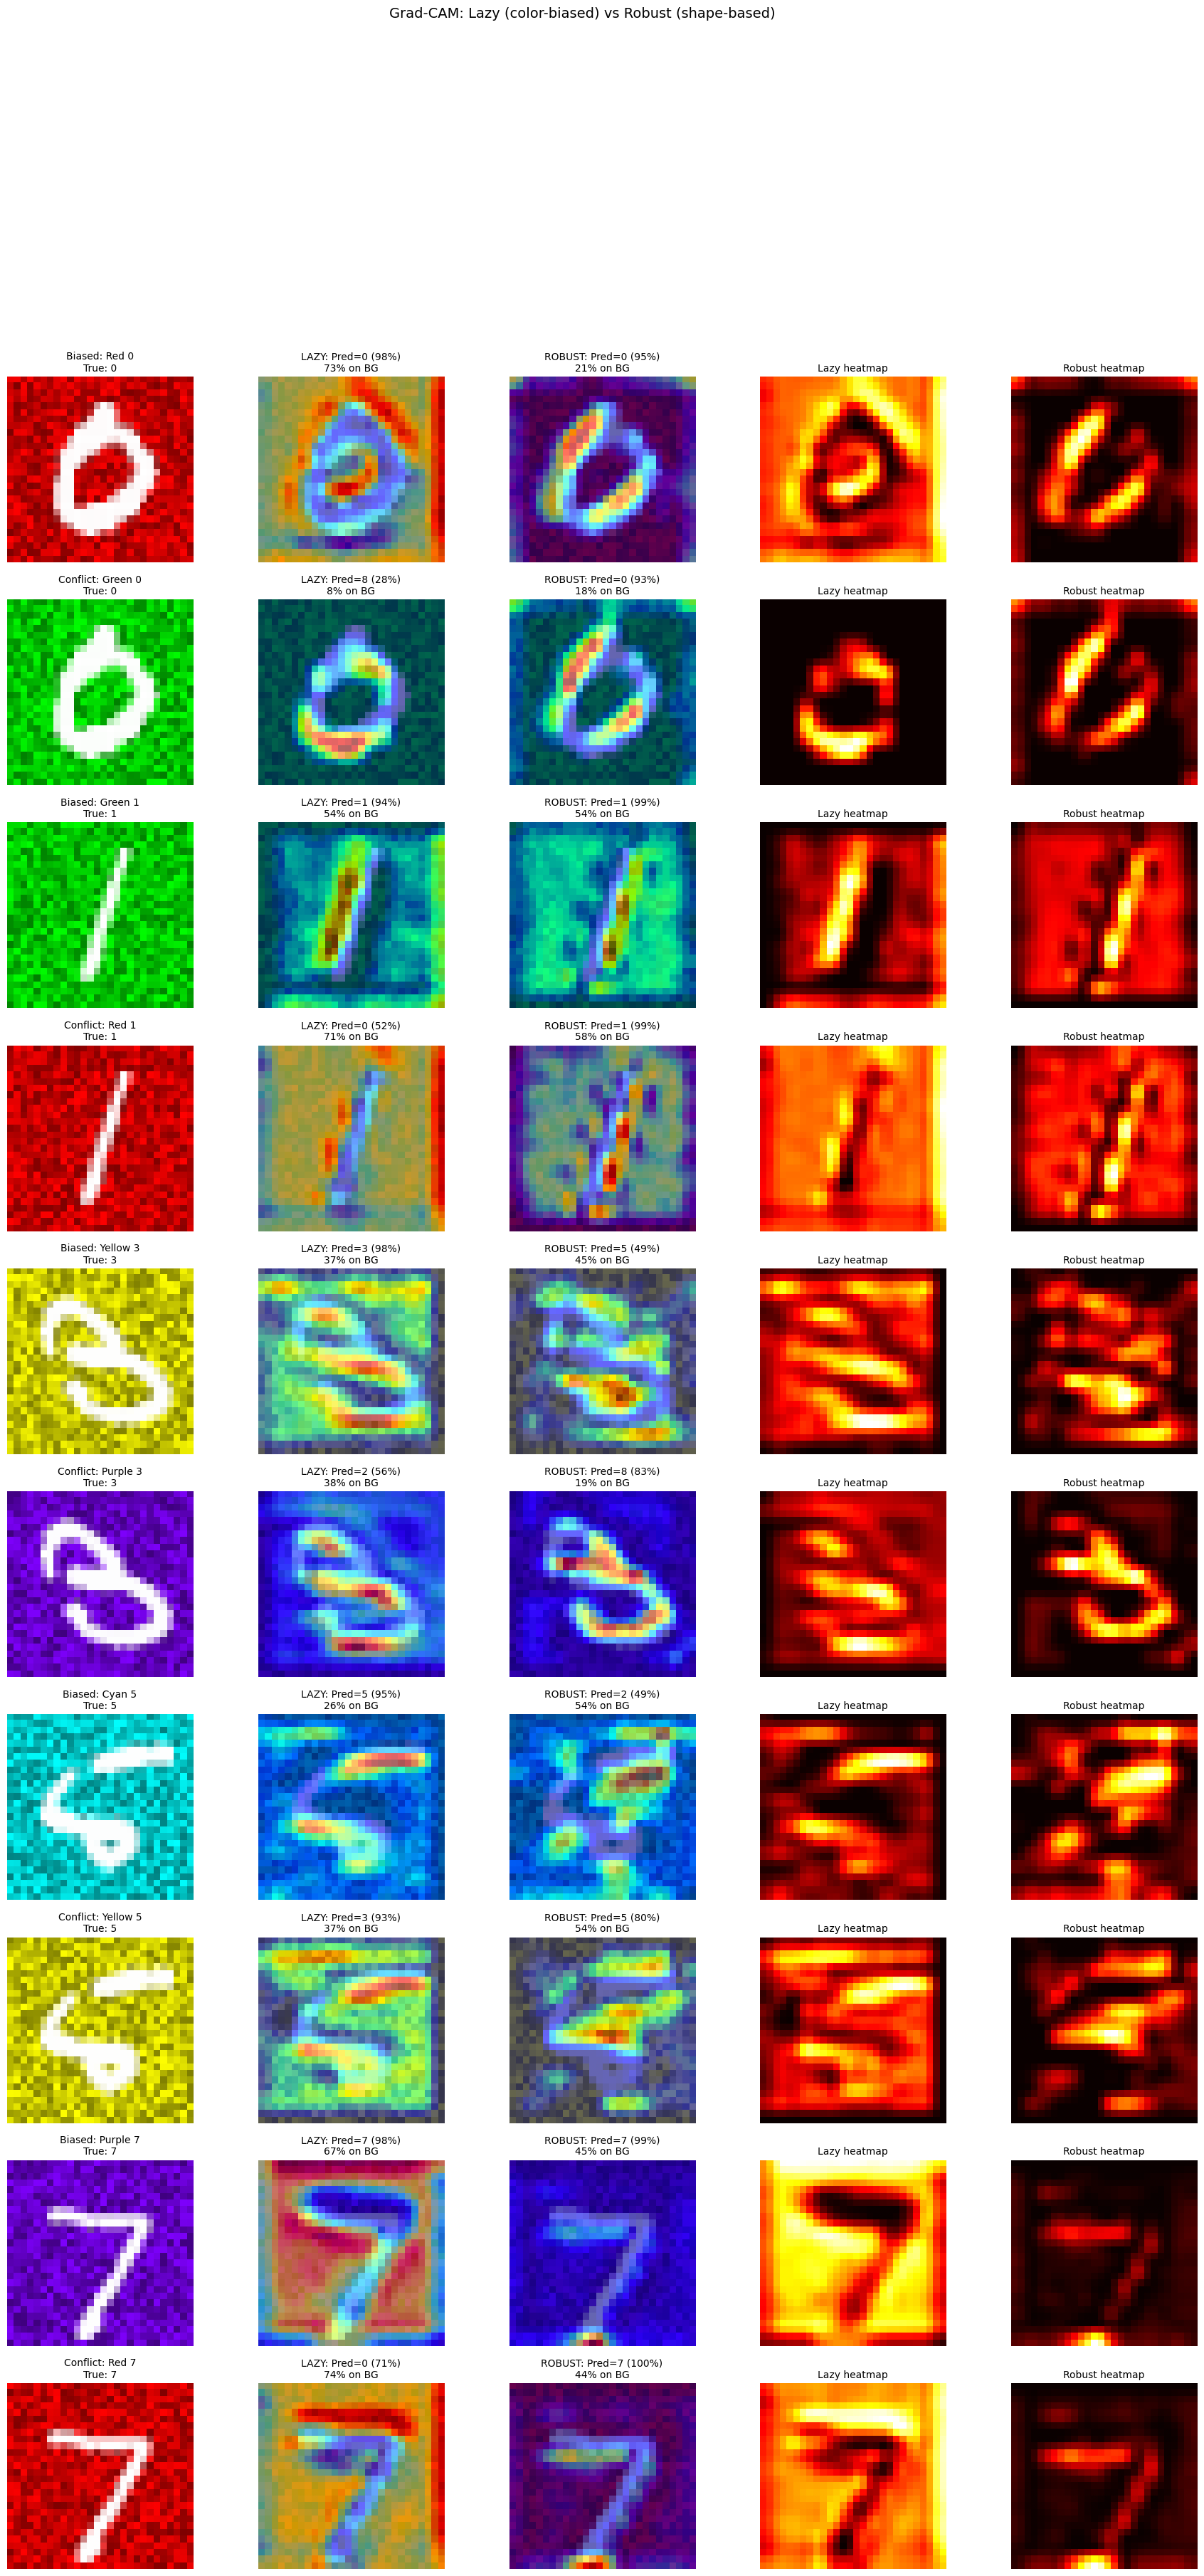

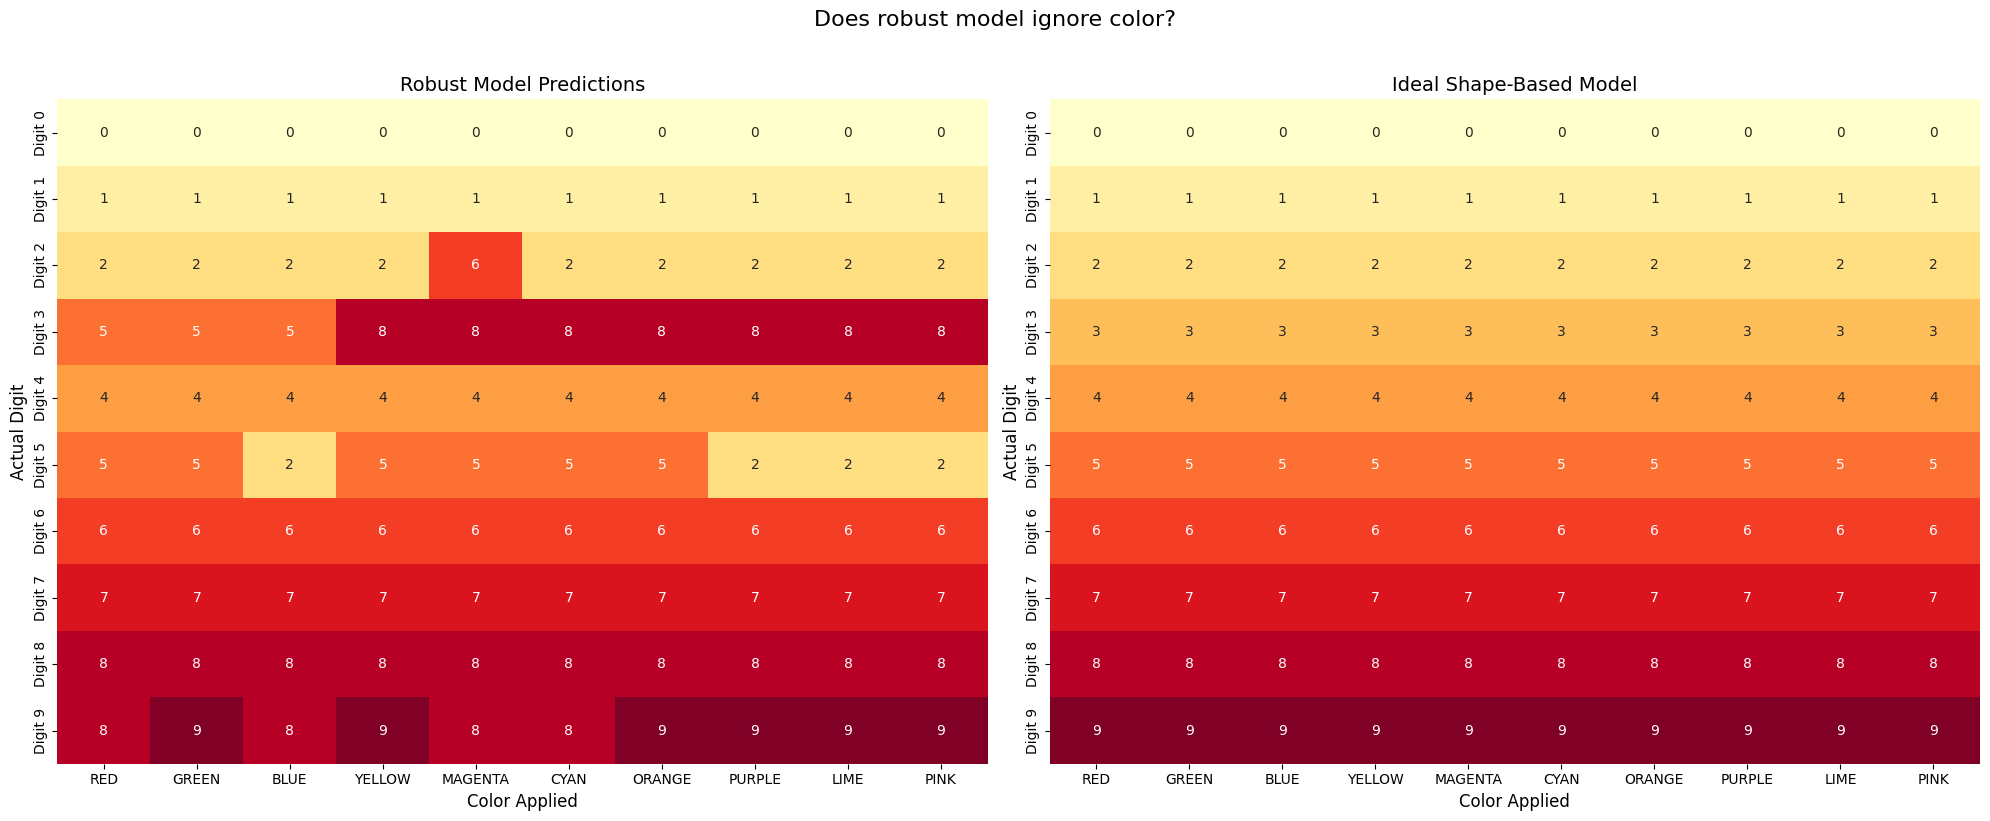

Verdict: 81/100 grid accuracy


In [17]:
test_cases = [
    (0, 0, "Biased: Red 0"),
    (0, 1, "Conflict: Green 0"),
    (1, 1, "Biased: Green 1"),
    (1, 0, "Conflict: Red 1"),
    (3, 3, "Biased: Yellow 3"),
    (3, 7, "Conflict: Purple 3"),
    (5, 5, "Biased: Cyan 5"),
    (5, 3, "Conflict: Yellow 5"),
    (7, 7, "Biased: Purple 7"),
    (7, 0, "Conflict: Red 7"),
]

fig, axes = plt.subplots(len(test_cases), 5, figsize=(22, 4 * len(test_cases)))

lazy_bg_pcts = []
robust_bg_pcts = []

for row, (digit, color_idx, title) in enumerate(test_cases):
    color = color_map[color_idx]
    colored_img = make_bg_textured(digit_images[digit], color, seed=42 + row)
    input_tensor = colored_img.unsqueeze(0).to(device)
    original_img = np.clip(colored_img.permute(1, 2, 0).cpu().numpy(), 0, 1)

    digit_mask = (digit_images[digit].squeeze().numpy() > 0.5).astype(float)
    bg_mask = 1 - digit_mask

    def measure_bg(heatmap):
        fg_d = np.mean(heatmap[digit_mask > 0.5]) if np.any(digit_mask > 0.5) else 0
        bg_d = np.mean(heatmap[bg_mask > 0.5]) if np.any(bg_mask > 0.5) else 0
        total = fg_d + bg_d
        return 100 * bg_d / total if total > 0 else 50

    gc_lazy = GradCAM(model, model.bn2)
    hm_lazy, pred_lazy, out_lazy = gc_lazy.generate_heatmap(input_tensor)
    conf_lazy = torch.softmax(out_lazy, dim=1)[0][pred_lazy].item()
    gc_lazy.remove_hooks()
    lazy_bg = measure_bg(hm_lazy)
    lazy_bg_pcts.append(lazy_bg)

    gc_robust = GradCAM(robust_model, robust_model.bn2)
    hm_robust, pred_robust, out_robust = gc_robust.generate_heatmap(input_tensor)
    conf_robust = torch.softmax(out_robust, dim=1)[0][pred_robust].item()
    gc_robust.remove_hooks()
    robust_bg = measure_bg(hm_robust)
    robust_bg_pcts.append(robust_bg)

    axes[row, 0].imshow(original_img)
    axes[row, 0].set_title(f"{title}\nTrue: {digit}", fontsize=10)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_img)
    axes[row, 1].imshow(hm_lazy, cmap='jet', alpha=0.6)
    axes[row, 1].set_title(f"LAZY: Pred={pred_lazy} ({conf_lazy:.0%})\n{lazy_bg:.0f}% on BG", fontsize=10)
    axes[row, 1].axis('off')

    axes[row, 2].imshow(original_img)
    axes[row, 2].imshow(hm_robust, cmap='jet', alpha=0.6)
    axes[row, 2].set_title(f"ROBUST: Pred={pred_robust} ({conf_robust:.0%})\n{robust_bg:.0f}% on BG", fontsize=10)
    axes[row, 2].axis('off')

    axes[row, 3].imshow(hm_lazy, cmap='hot')
    axes[row, 3].set_title(f"Lazy heatmap", fontsize=10)
    axes[row, 3].axis('off')

    axes[row, 4].imshow(hm_robust, cmap='hot')
    axes[row, 4].set_title(f"Robust heatmap", fontsize=10)
    axes[row, 4].axis('off')

plt.suptitle("Grad-CAM: Lazy (color-biased) vs Robust (shape-based)",
             fontsize=14, y=1.01)
print(f"Avg BG focus -- Lazy: {np.mean(lazy_bg_pcts):.1f}% | Robust: {np.mean(robust_bg_pcts):.1f}%")

print("\nColor-swap litmus test: all digits colored RED")

model.eval()
robust_model.eval()
lazy_color_count = 0
robust_shape_count = 0

with torch.no_grad():
    for digit in range(10):
        red_img = make_bg_textured(digit_images[digit], color_map[0], seed=100)
        inp = red_img.unsqueeze(0).to(device)

        out_l = model(inp)
        pred_l = out_l.argmax(1).item()
        conf_l = torch.softmax(out_l, 1)[0, pred_l].item()
        if pred_l == 0: lazy_color_count += 1

        out_r = robust_model(inp)
        pred_r = out_r.argmax(1).item()
        conf_r = torch.softmax(out_r, 1)[0, pred_r].item()
        if pred_r == digit: robust_shape_count += 1

        lazy_tag = "COLOR" if pred_l == 0 else "SHAPE" if pred_l == digit else "???"
        robust_tag = "SHAPE" if pred_r == digit else "COLOR" if pred_r == 0 else "???"
        print(f"  Red {digit} -> Lazy: {pred_l} ({conf_l:.0%}) [{lazy_tag}]  |  Robust: {pred_r} ({conf_r:.0%}) [{robust_tag}]")

print(f"\nLazy follows COLOR: {lazy_color_count}/10")
print(f"Robust follows SHAPE: {robust_shape_count}/10")

print("\n10x10 prediction grid (robust model)")

NUM_SAMPLES = 10
pred_grid_robust = np.zeros((10, 10), dtype=int)

robust_model.eval()
with torch.no_grad():
    for d in range(10):
        for c in range(10):
            votes = np.zeros(10)
            for s in range(NUM_SAMPLES):
                ci = make_bg_textured(digit_images[d], color_map[c], seed=1000*d+100*c+s)
                out = robust_model(ci.unsqueeze(0).to(device))
                votes[out.argmax(1).item()] += 1
            pred_grid_robust[d][c] = np.argmax(votes)

header = f"{'':>8}" + "".join(f"{cn:>8}" for cn in color_names)
print(header)
for d in range(10):
    row_str = f"Digit {d}: "
    for c in range(10):
        p = pred_grid_robust[d][c]
        marker = " " if p == d else "X"
        row_str += f"{p:>6}{marker} "
    print(row_str)

correct_cells = sum(1 for d in range(10) for c in range(10) if pred_grid_robust[d][c] == d)
print(f"\nGrid accuracy: {correct_cells}/100")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(pred_grid_robust, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=color_names, yticklabels=[f'Digit {i}' for i in range(10)],
            ax=axes[0], cbar=False, vmin=0, vmax=9)
axes[0].set_title("Robust Model Predictions", fontsize=14)
axes[0].set_xlabel("Color Applied", fontsize=12)
axes[0].set_ylabel("Actual Digit", fontsize=12)

ideal_shape = np.tile(np.arange(10).reshape(-1, 1), (1, 10))
sns.heatmap(ideal_shape, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=color_names, yticklabels=[f'Digit {i}' for i in range(10)],
            ax=axes[1], cbar=False, vmin=0, vmax=9)
axes[1].set_title("Ideal Shape-Based Model", fontsize=14)
axes[1].set_xlabel("Color Applied", fontsize=12)
axes[1].set_ylabel("Actual Digit", fontsize=12)

plt.suptitle("Does robust model ignore color?", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print(f"Verdict: {correct_cells}/100 grid accuracy")

# Task 3: The Interrogation

Implement Grad-CAM and other attribution methods to figure out whether the model looks at digit shapes or background color. We hook bn2 (14x14 feature maps), compute gradient-weighted channel activations, and upsample the resulting heatmap to 28x28. We also run pixel-level methods (gradient saliency, occlusion sensitivity, GradCAM at bn1) at full 28x28 resolution to avoid the blurriness that comes with upsampling lower-resolution feature maps. A causal ablation experiment directly erases or swaps image regions to confirm what the model actually relies on.

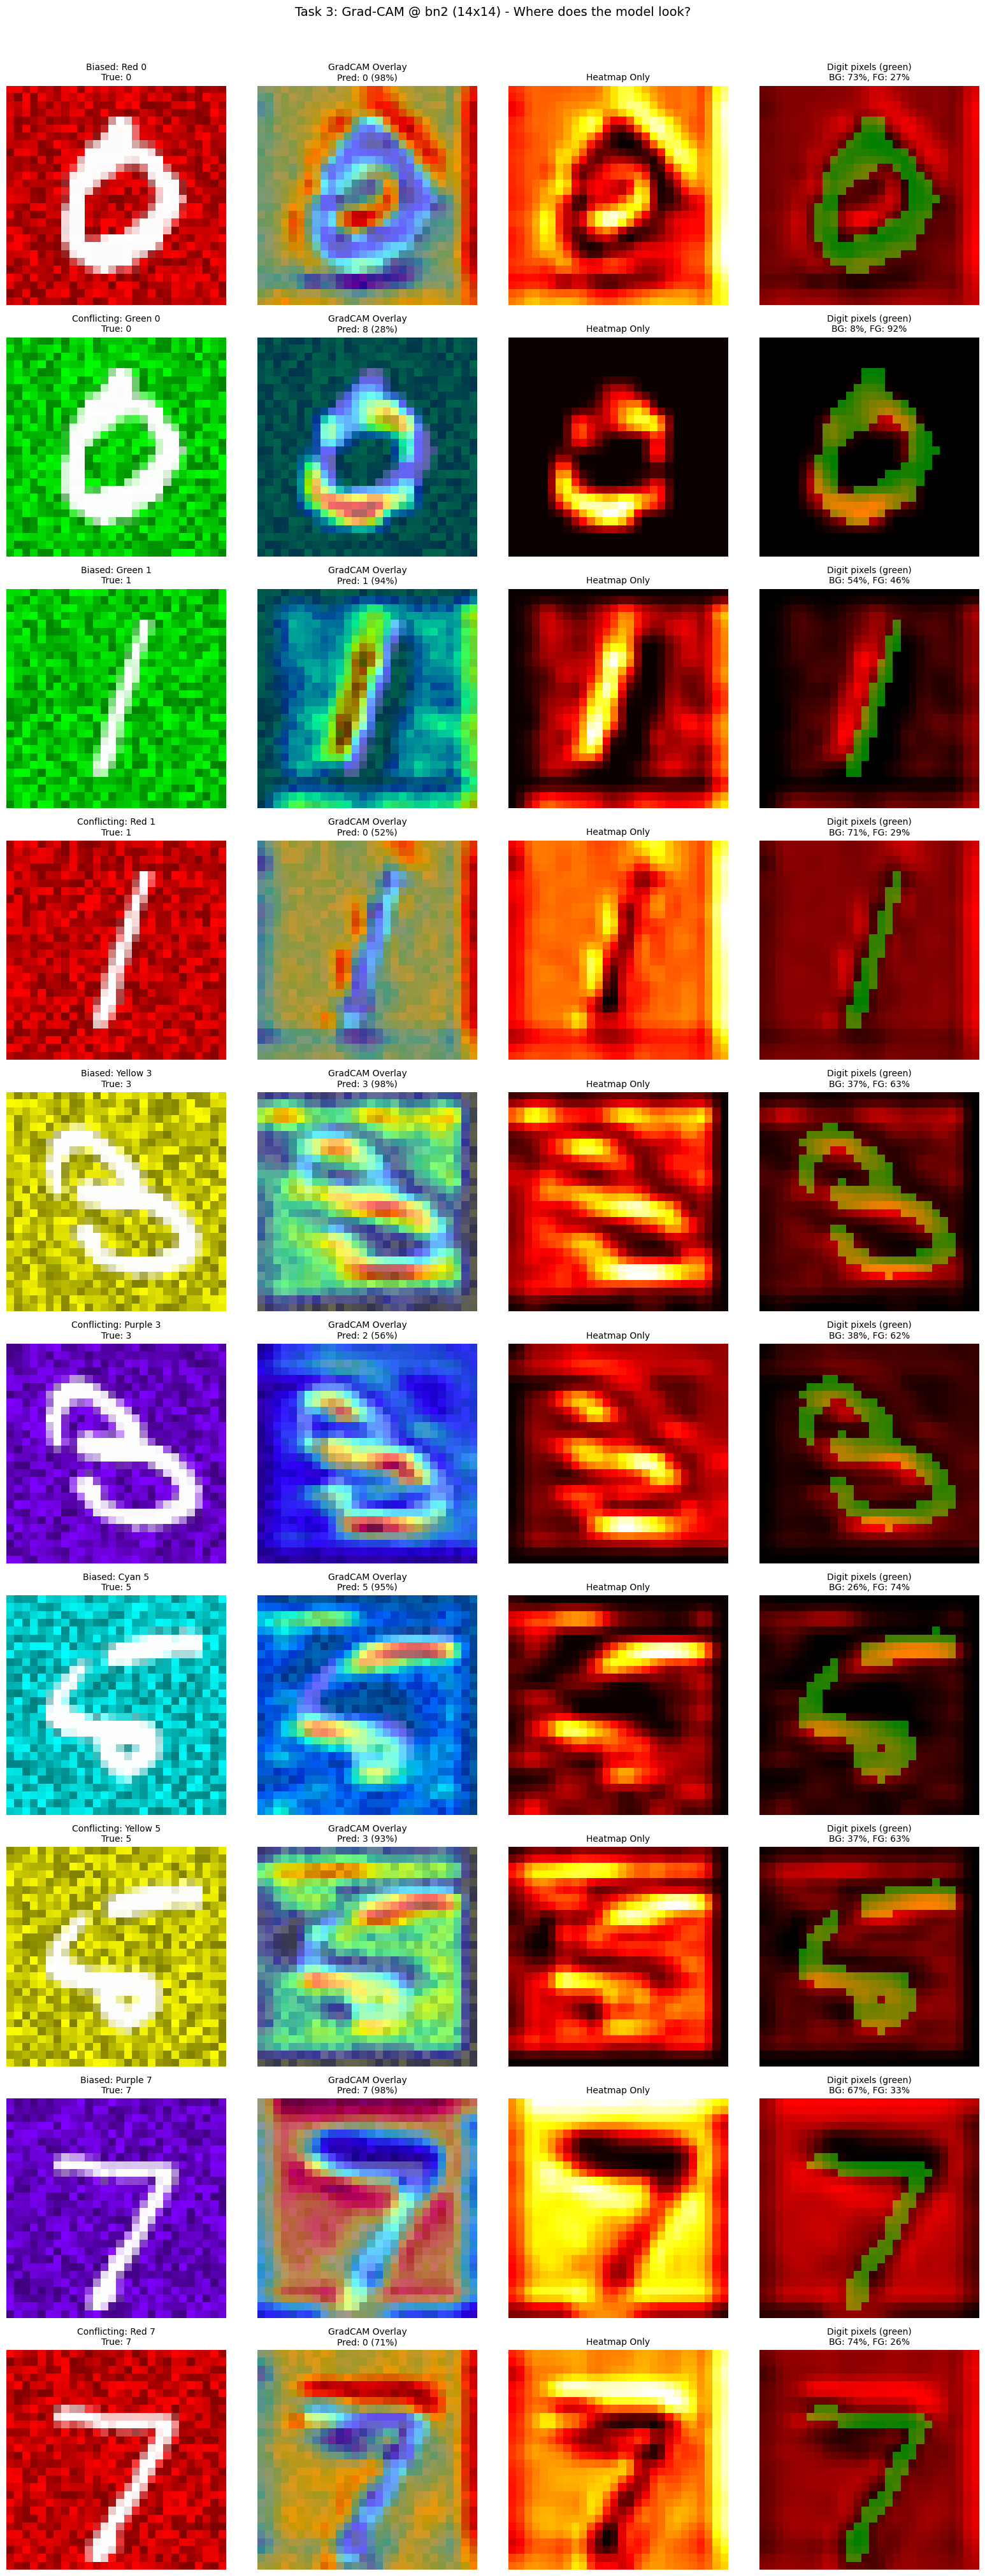

Biased: Red 0: pred=0 (98%), BG=72.9%, FG=27.1%
Conflicting: Green 0: pred=8 (28%), BG=8.3%, FG=91.7%
Biased: Green 1: pred=1 (94%), BG=53.5%, FG=46.5%
Conflicting: Red 1: pred=0 (52%), BG=71.1%, FG=28.9%
Biased: Yellow 3: pred=3 (98%), BG=36.6%, FG=63.4%
Conflicting: Purple 3: pred=2 (56%), BG=37.7%, FG=62.3%
Biased: Cyan 5: pred=5 (95%), BG=25.9%, FG=74.1%
Conflicting: Yellow 5: pred=3 (93%), BG=36.6%, FG=63.4%
Biased: Purple 7: pred=7 (98%), BG=66.7%, FG=33.3%
Conflicting: Red 7: pred=0 (71%), BG=73.9%, FG=26.1%

Summary: biased cases avg BG% = 51.2%; conflicting cases avg BG% = 45.5%
Conflict cases: color_follow=3, shape_follow=0, neither=2


In [18]:
grad_cam = GradCAM(model, model.bn2)

test_cases = [
    (0, 0, "Biased: Red 0"),
    (0, 1, "Conflicting: Green 0"),
    (1, 1, "Biased: Green 1"),
    (1, 0, "Conflicting: Red 1"),
    (3, 3, "Biased: Yellow 3"),
    (3, 7, "Conflicting: Purple 3"),
    (5, 5, "Biased: Cyan 5"),
    (5, 3, "Conflicting: Yellow 5"),
    (7, 7, "Biased: Purple 7"),
    (7, 0, "Conflicting: Red 7"),
]

fig, axes = plt.subplots(len(test_cases), 4, figsize=(16, 4 * len(test_cases)))

case_results = []
quantitative_results = []

for row, (digit, color_idx, title) in enumerate(test_cases):
    color = color_map[color_idx]
    colored_img = make_bg_textured(digit_images[digit], color, seed=42 + row)
    input_tensor = colored_img.unsqueeze(0).to(device)

    heatmap, pred_class, output = grad_cam.generate_heatmap(input_tensor)
    conf = torch.softmax(output, dim=1)[0][pred_class].item()

    case_results.append((digit, color_idx, title, pred_class, conf))

    digit_mask = (digit_images[digit].squeeze().numpy() > 0.5).astype(float)
    bg_mask = 1 - digit_mask

    fg_mean = np.mean(heatmap[digit_mask > 0.5]) if np.any(digit_mask > 0.5) else 0
    bg_mean = np.mean(heatmap[bg_mask > 0.5]) if np.any(bg_mask > 0.5) else 0
    total_energy = fg_mean + bg_mean
    bg_percentage = 100 * bg_mean / total_energy if total_energy > 0 else 50
    fg_percentage = 100 * fg_mean / total_energy if total_energy > 0 else 50

    quantitative_results.append((title, bg_percentage, fg_percentage))

    original_img = np.clip(colored_img.permute(1, 2, 0).cpu().numpy(), 0, 1)

    axes[row, 0].imshow(original_img)
    axes[row, 0].set_title(f"{title}\nTrue: {digit}", fontsize=10)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_img)
    axes[row, 1].imshow(heatmap, cmap='jet', alpha=0.6)
    axes[row, 1].set_title(f"GradCAM Overlay\nPred: {pred_class} ({conf:.0%})", fontsize=10)
    axes[row, 1].axis('off')

    axes[row, 2].imshow(heatmap, cmap='hot')
    axes[row, 2].set_title("Heatmap Only", fontsize=10)
    axes[row, 2].axis('off')

    hmap_with_mask = np.zeros((28, 28, 3))
    hmap_with_mask[:, :, 0] = heatmap
    hmap_with_mask[digit_mask > 0.5, 1] = 0.5
    axes[row, 3].imshow(hmap_with_mask)
    axes[row, 3].set_title(f"Digit pixels (green)\nBG: {bg_percentage:.0f}%, FG: {fg_percentage:.0f}%", fontsize=10)
    axes[row, 3].axis('off')

plt.suptitle("Task 3: Grad-CAM @ bn2 (14x14) - Where does the model look?",
             fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

grad_cam.remove_hooks()

# Summarize results concisely
biased_cases = [c for c in case_results if c[0] == c[1]]
conflict_cases = [c for c in case_results if c[0] != c[1]]

# Print concise per-case summaries
for digit, color_idx, title, pred, conf in case_results:
    # find bg/fg percentages
    for t, bg_pct, fg_pct in quantitative_results:
        if t == title:
            print(f"{title}: pred={pred} ({conf:.0%}), BG={bg_pct:.1f}%, FG={fg_pct:.1f}%")
            break

# Aggregate counts
color_follows = sum(1 for d, c, t, p, f in conflict_cases if p == c)
shape_follows = sum(1 for d, c, t, p, f in conflict_cases if p == d)
neither = len(conflict_cases) - color_follows - shape_follows

avg_bg_biased = np.mean([bg for t, bg, fg in quantitative_results if any(t == title for _, _, title, _, _ in biased_cases)])
avg_bg_conflict = np.mean([bg for t, bg, fg in quantitative_results if any(t == title for _, _, title, _, _ in conflict_cases)])

print(f"\nSummary: biased cases avg BG% = {avg_bg_biased:.1f}%; conflicting cases avg BG% = {avg_bg_conflict:.1f}%")
print(f"Conflict cases: color_follow={color_follows}, shape_follow={shape_follows}, neither={neither}")

Pixel-level attribution (28x28 resolution)


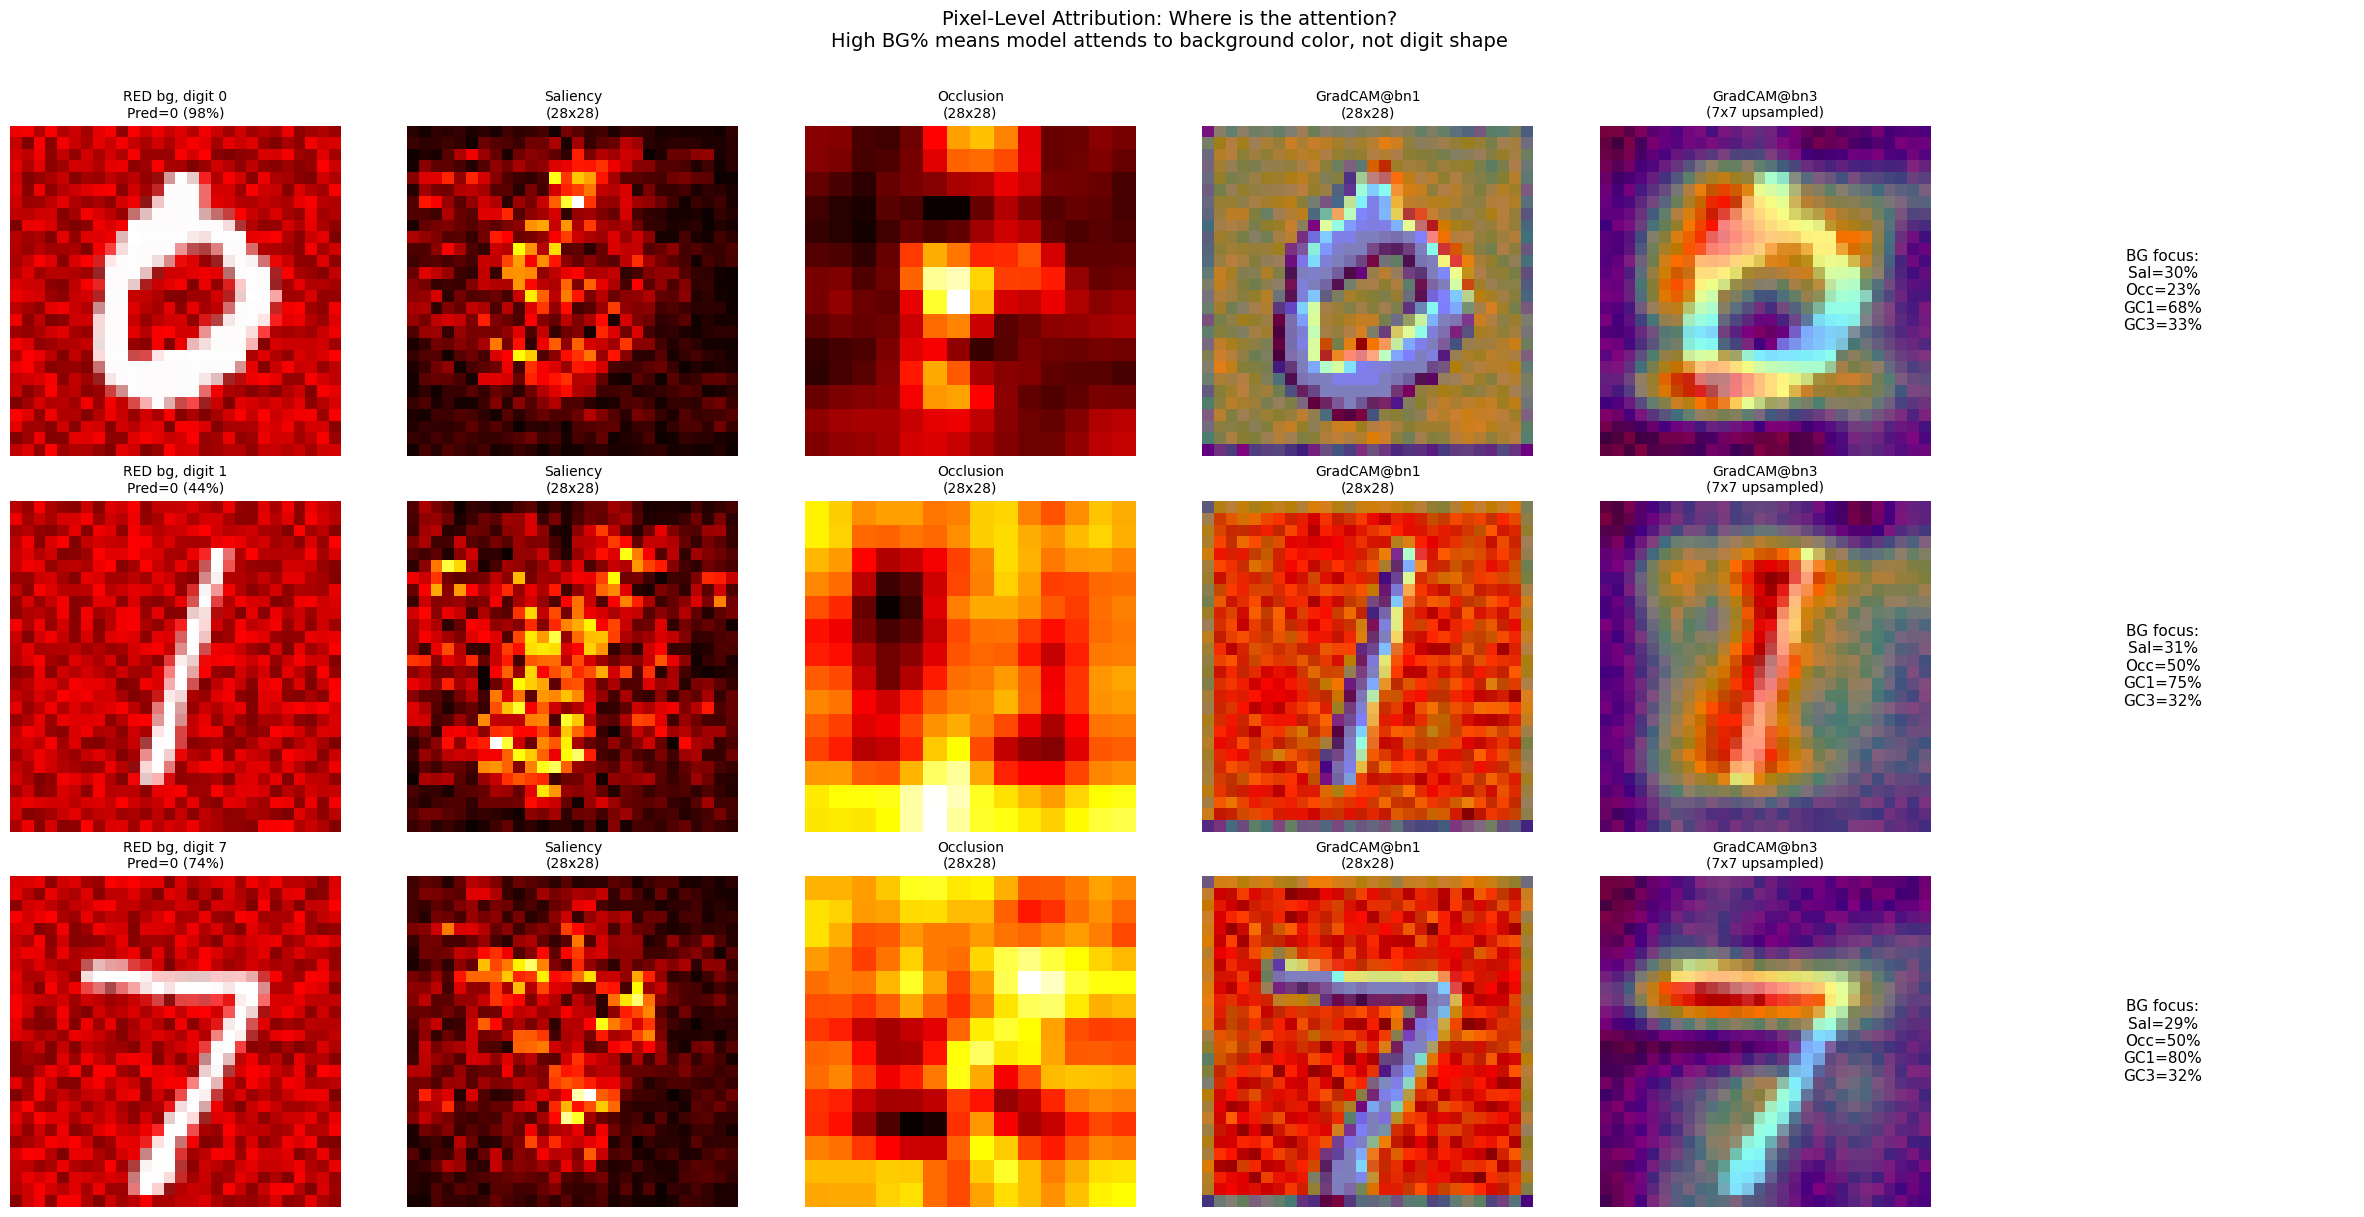


Saliency + occlusion confirm background focus.


In [19]:

print("Pixel-level attribution (28x28 resolution)")

model.eval()

cases = [
    (0, 0, "RED bg, digit 0"),
    (1, 0, "RED bg, digit 1"),
    (7, 0, "RED bg, digit 7"),
]

fig, axes = plt.subplots(len(cases), 6, figsize=(24, 4 * len(cases)))

for row, (digit, cidx, desc) in enumerate(cases):
    color = color_map[cidx]
    colored_img = make_bg_textured(digit_images[digit], color, seed=42 + row)

    # Gradient saliency (28x28)
    inp = colored_img.unsqueeze(0).to(device).clone().requires_grad_(True)
    out = model(inp)
    pred = out.argmax(1).item()
    conf = torch.softmax(out, 1)[0, pred].item()
    out[0, pred].backward()
    grad = inp.grad.data[0].cpu()
    saliency = grad.abs().max(dim=0)[0].numpy()

    # Occlusion sensitivity (28x28)
    patch_sz, stride = 4, 2
    occ_map = np.zeros((28, 28))
    occ_cnt = np.zeros((28, 28))
    with torch.no_grad():
        base_conf = model(colored_img.unsqueeze(0).to(device)).softmax(1)[0, pred].item()
        for oi in range(0, 28 - patch_sz + 1, stride):
            for oj in range(0, 28 - patch_sz + 1, stride):
                masked = colored_img.clone()
                masked[:, oi:oi+patch_sz, oj:oj+patch_sz] = 0.5
                new_conf = model(masked.unsqueeze(0).to(device)).softmax(1)[0, pred].item()
                drop = base_conf - new_conf
                occ_map[oi:oi+patch_sz, oj:oj+patch_sz] += drop
                occ_cnt[oi:oi+patch_sz, oj:oj+patch_sz] += 1
    occ_map = occ_map / (occ_cnt + 1e-8)

    # GradCAM @ bn1 (28x28 native)
    gc1 = GradCAM(model, model.bn1)
    hm1, _, _ = gc1.generate_heatmap(inp)
    gc1.remove_hooks()

    # GradCAM @ bn3 (7x7 upsampled)
    gc3 = GradCAM(model, model.bn3)
    hm3, _, _ = gc3.generate_heatmap(inp)
    gc3.remove_hooks()

    orig_np = np.clip(colored_img.permute(1, 2, 0).cpu().numpy(), 0, 1)

    axes[row, 0].imshow(orig_np)
    axes[row, 0].set_title(f"{desc}\nPred={pred} ({conf:.0%})", fontsize=10)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(saliency, cmap='hot')
    axes[row, 1].set_title("Saliency\n(28x28)", fontsize=10)
    axes[row, 1].axis('off')

    axes[row, 2].imshow(occ_map, cmap='hot')
    axes[row, 2].set_title("Occlusion\n(28x28)", fontsize=10)
    axes[row, 2].axis('off')

    axes[row, 3].imshow(orig_np)
    axes[row, 3].imshow(hm1, cmap='jet', alpha=0.5)
    axes[row, 3].set_title("GradCAM@bn1\n(28x28)", fontsize=10)
    axes[row, 3].axis('off')

    axes[row, 4].imshow(orig_np)
    axes[row, 4].imshow(hm3, cmap='jet', alpha=0.5)
    axes[row, 4].set_title("GradCAM@bn3\n(7x7 upsampled)", fontsize=10)
    axes[row, 4].axis('off')

    digit_mask = (digit_images[digit].squeeze().numpy() > 0.5).astype(float)
    bg_mask = 1 - digit_mask

    def measure(hmap):
        fg = np.mean(hmap[digit_mask > 0.5]) if np.any(digit_mask > 0.5) else 0
        bg = np.mean(hmap[bg_mask > 0.5]) if np.any(bg_mask > 0.5) else 0
        total = fg + bg
        return 100 * bg / total if total > 0 else 50

    s_bg = measure(saliency)
    o_bg = measure(occ_map)
    h1_bg = measure(hm1)
    h3_bg = measure(hm3)

    summary = f"BG focus:\nSal={s_bg:.0f}%\nOcc={o_bg:.0f}%\nGC1={h1_bg:.0f}%\nGC3={h3_bg:.0f}%"
    axes[row, 5].text(0.5, 0.5, summary, ha='center', va='center',
                      fontsize=11, transform=axes[row, 5].transAxes)
    axes[row, 5].axis('off')

plt.suptitle("Pixel-Level Attribution: Where is the attention?\n"
             "High BG% means model attends to background color, not digit shape",
             fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print("\nSaliency + occlusion confirm background focus.")

Causal ablation: what does the model actually rely on?


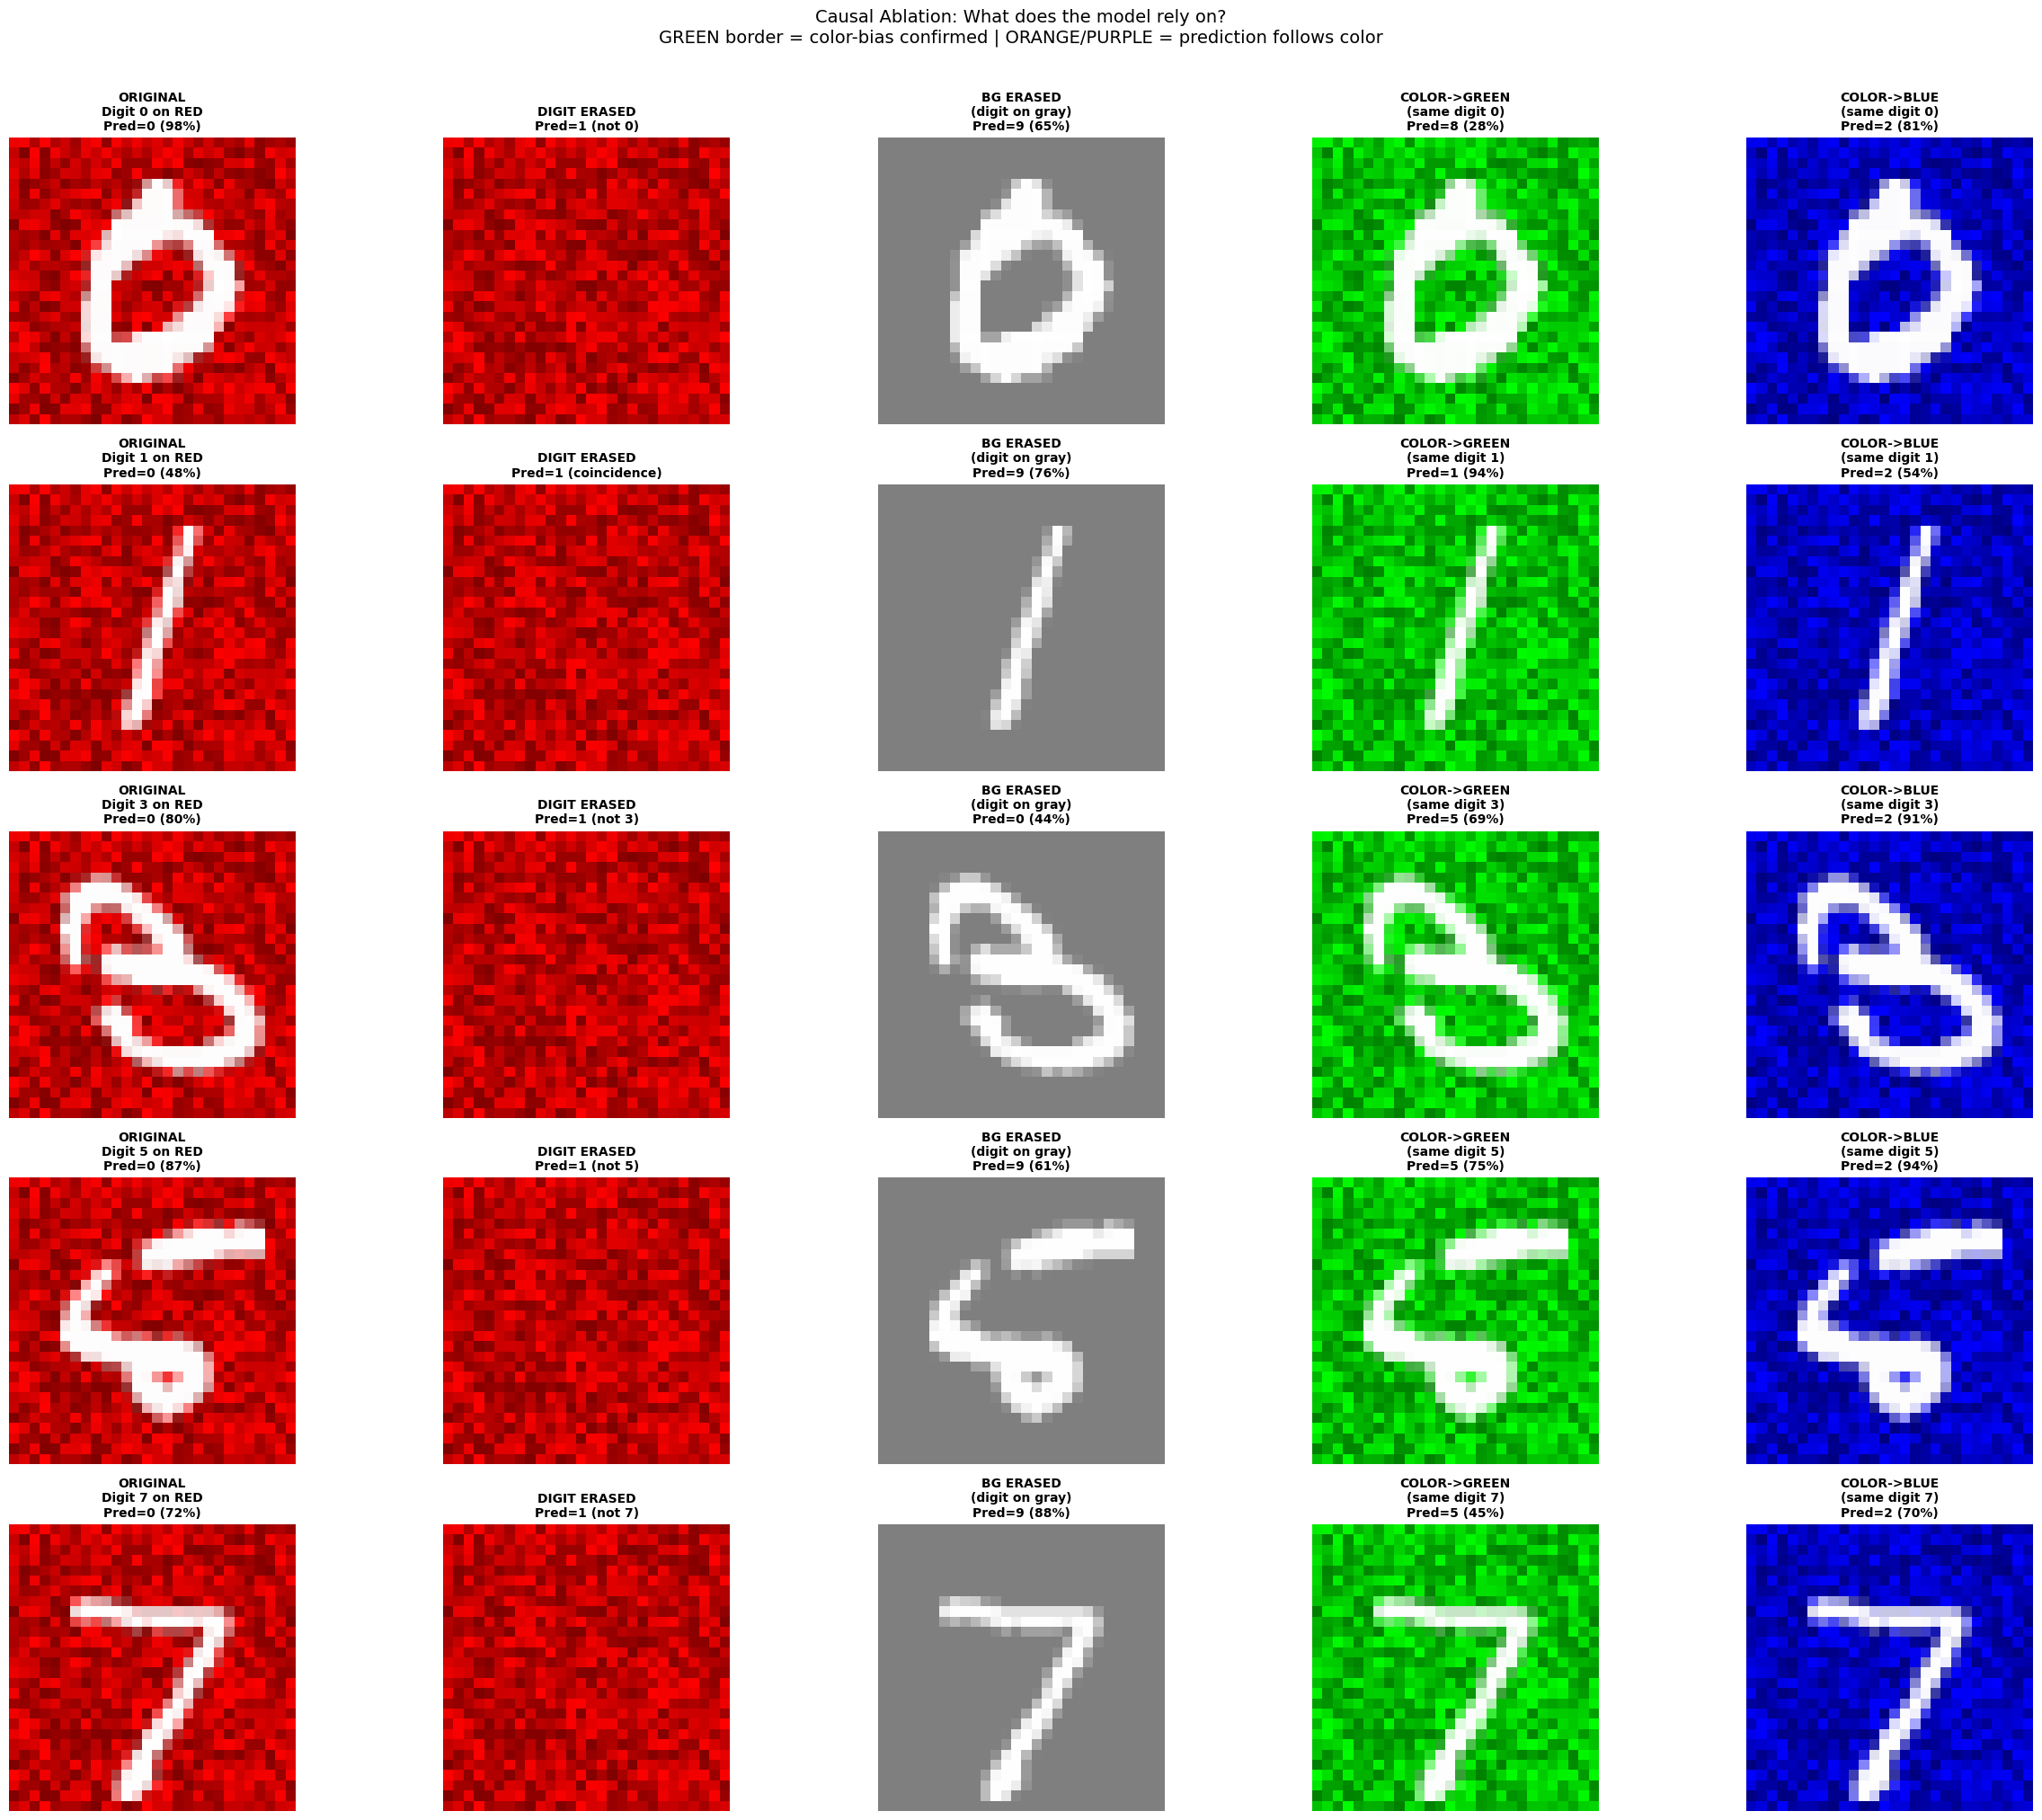


Ablation results:
  Digit erased, model doesn't predict shape: 4/5
  BG erased, prediction changed: 4/5
  Green swap follows color: 1/5
  Blue swap follows color: 5/5
  Both swaps follow color: 1/5
Conclusion: model classifies by background color, not digit shape.


In [20]:

print("Causal ablation: what does the model actually rely on?")

model.eval()

test_digits = [0, 1, 3, 5, 7]
n_tests = len(test_digits)
digit_erased_not_shape = 0
bg_erased_changed = 0
color_swap_follows_color = 0
green_follows_color = 0
blue_follows_color = 0

fig, axes = plt.subplots(n_tests, 5, figsize=(25, 4 * n_tests))

for row, digit in enumerate(test_digits):
    color = color_map[0]  # RED background
    original = make_bg_textured(digit_images[digit], color, seed=42)

    # A) Original
    with torch.no_grad():
        out = model(original.unsqueeze(0).to(device))
        pred_a = out.argmax(1).item()
        conf_a = torch.softmax(out, 1)[0][pred_a].item()

    # B) Digit erased: pure colored background
    black_img = torch.zeros(1, 28, 28)
    no_digit = make_bg_textured(black_img, color, seed=42)
    with torch.no_grad():
        out = model(no_digit.unsqueeze(0).to(device))
        pred_b = out.argmax(1).item()
        conf_b = torch.softmax(out, 1)[0][pred_b].item()
    if pred_b != digit:
        digit_erased_not_shape += 1

    # C) Background erased: digit on neutral gray
    dm = digit_images[digit]
    no_bg = (0.5 + 0.5 * dm).expand(3, -1, -1)
    with torch.no_grad():
        out = model(no_bg.unsqueeze(0).to(device))
        pred_c = out.argmax(1).item()
        conf_c = torch.softmax(out, 1)[0][pred_c].item()
    if pred_c != pred_a:
        bg_erased_changed += 1

    # D) Color swap to GREEN
    green = make_bg_textured(digit_images[digit], color_map[1], seed=42)
    with torch.no_grad():
        out = model(green.unsqueeze(0).to(device))
        pred_d = out.argmax(1).item()
        conf_d = torch.softmax(out, 1)[0][pred_d].item()

    # E) Color swap to BLUE
    blue = make_bg_textured(digit_images[digit], color_map[2], seed=42)
    with torch.no_grad():
        out = model(blue.unsqueeze(0).to(device))
        pred_e = out.argmax(1).item()
        conf_e = torch.softmax(out, 1)[0][pred_e].item()

    # Check: does prediction follow the swapped color?
    if pred_d == 1: green_follows_color += 1
    if pred_e == 2: blue_follows_color += 1
    if pred_d == 1 and pred_e == 2:
        color_swap_follows_color += 1

    # Visualization
    if pred_b != digit:
        de_title = f"DIGIT ERASED\nPred={pred_b} (not {digit})"
        de_color = '#4CAF50'
    else:
        de_title = f"DIGIT ERASED\nPred={pred_b} (coincidence)"
        de_color = '#FFC107'

    all_tests = [
        (original,  f"ORIGINAL\nDigit {digit} on RED\nPred={pred_a} ({conf_a:.0%})", '#2196F3'),
        (no_digit,  de_title, de_color),
        (no_bg,     f"BG ERASED\n(digit on gray)\nPred={pred_c} ({conf_c:.0%})",
         '#4CAF50' if pred_c != pred_a else '#F44336'),
        (green,     f"COLOR->GREEN\n(same digit {digit})\nPred={pred_d} ({conf_d:.0%})",
         '#FF9800' if pred_d != digit else '#9E9E9E'),
        (blue,      f"COLOR->BLUE\n(same digit {digit})\nPred={pred_e} ({conf_e:.0%})",
         '#9C27B0' if pred_e != digit else '#9E9E9E'),
    ]

    for col, (img_t, title, bc) in enumerate(all_tests):
        img_np = np.clip(img_t.permute(1, 2, 0).cpu().numpy(), 0, 1)
        axes[row, col].imshow(img_np)
        axes[row, col].set_title(title, fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
        for s in axes[row, col].spines.values():
            s.set_visible(True)
            s.set_linewidth(3)
            s.set_edgecolor(bc)

plt.suptitle(
    "Causal Ablation: What does the model rely on?\n"
    "GREEN border = color-bias confirmed | ORANGE/PURPLE = prediction follows color",
    fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print(f"\nAblation results:")
print(f"  Digit erased, model doesn't predict shape: {digit_erased_not_shape}/{n_tests}")
print(f"  BG erased, prediction changed: {bg_erased_changed}/{n_tests}")
print(f"  Green swap follows color: {green_follows_color}/{n_tests}")
print(f"  Blue swap follows color: {blue_follows_color}/{n_tests}")
print(f"  Both swaps follow color: {color_swap_follows_color}/{n_tests}")
print(f"Conclusion: model classifies by background color, not digit shape.")

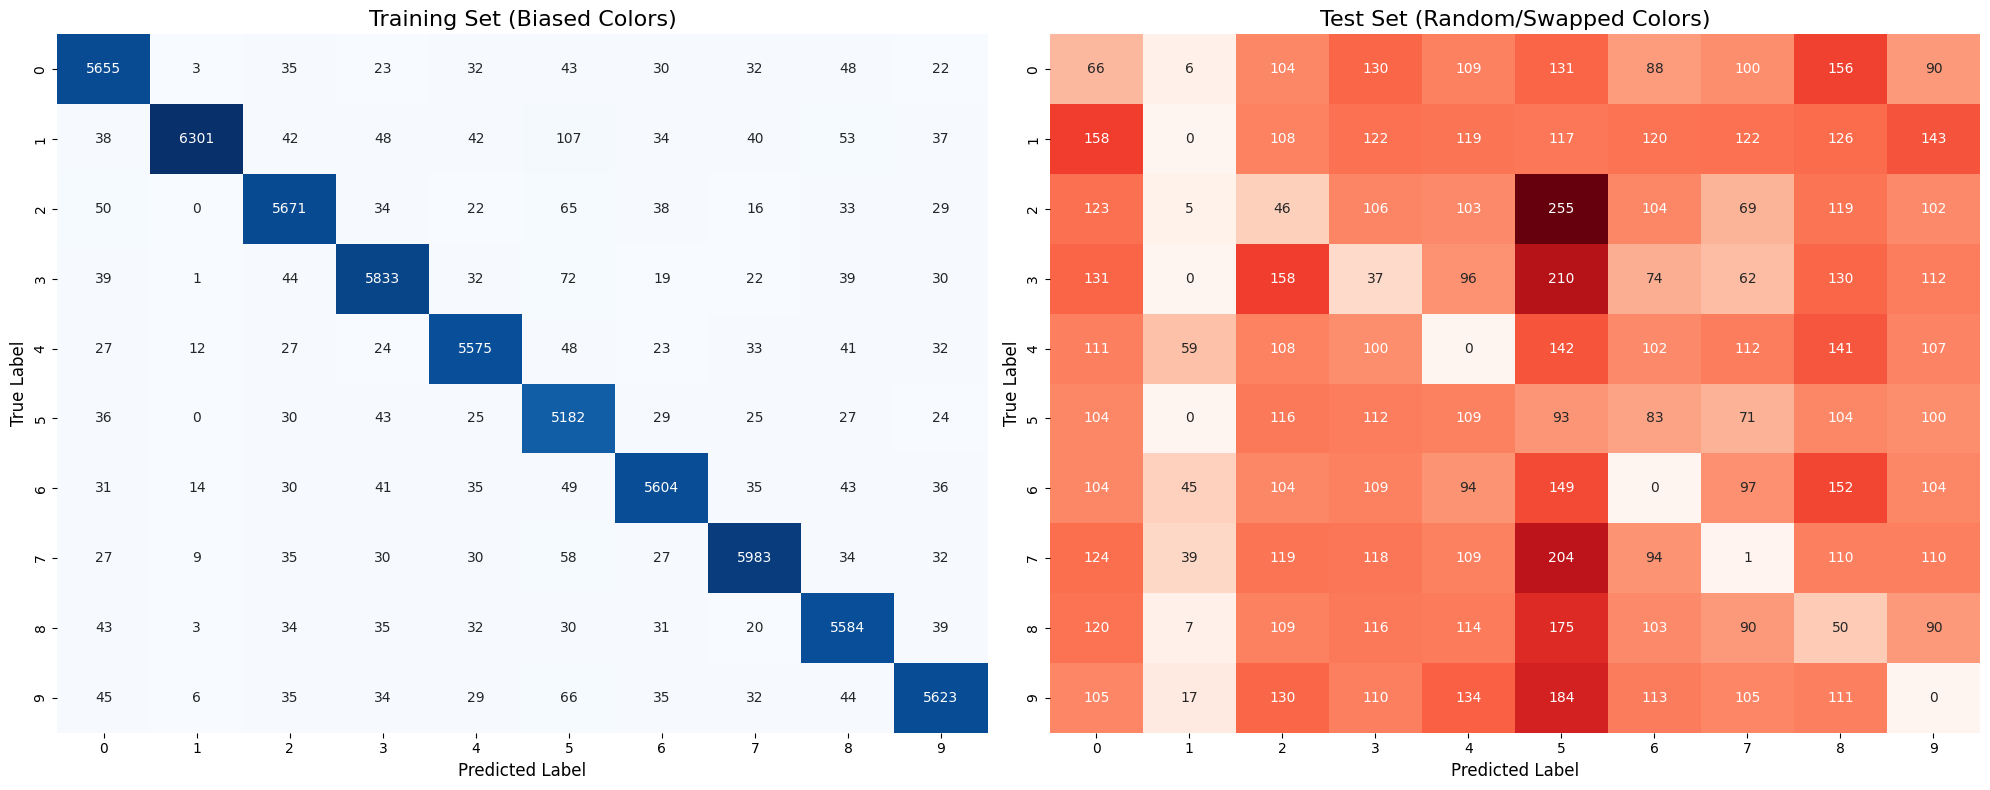

In [21]:
def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

train_preds, train_labels = get_all_preds(model, train_loader)
test_preds, test_labels = get_all_preds(model, test_loader)

cm_train = confusion_matrix(train_labels, train_preds)
cm_test = confusion_matrix(test_labels, test_preds)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title("Training Set (Biased Colors)", fontsize=16)
axes[0].set_xlabel("Predicted Label", fontsize=12)
axes[0].set_ylabel("True Label", fontsize=12)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', ax=axes[1], cbar=False)
axes[1].set_title("Test Set (Random/Swapped Colors)", fontsize=16)
axes[1].set_xlabel("Predicted Label", fontsize=12)
axes[1].set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()

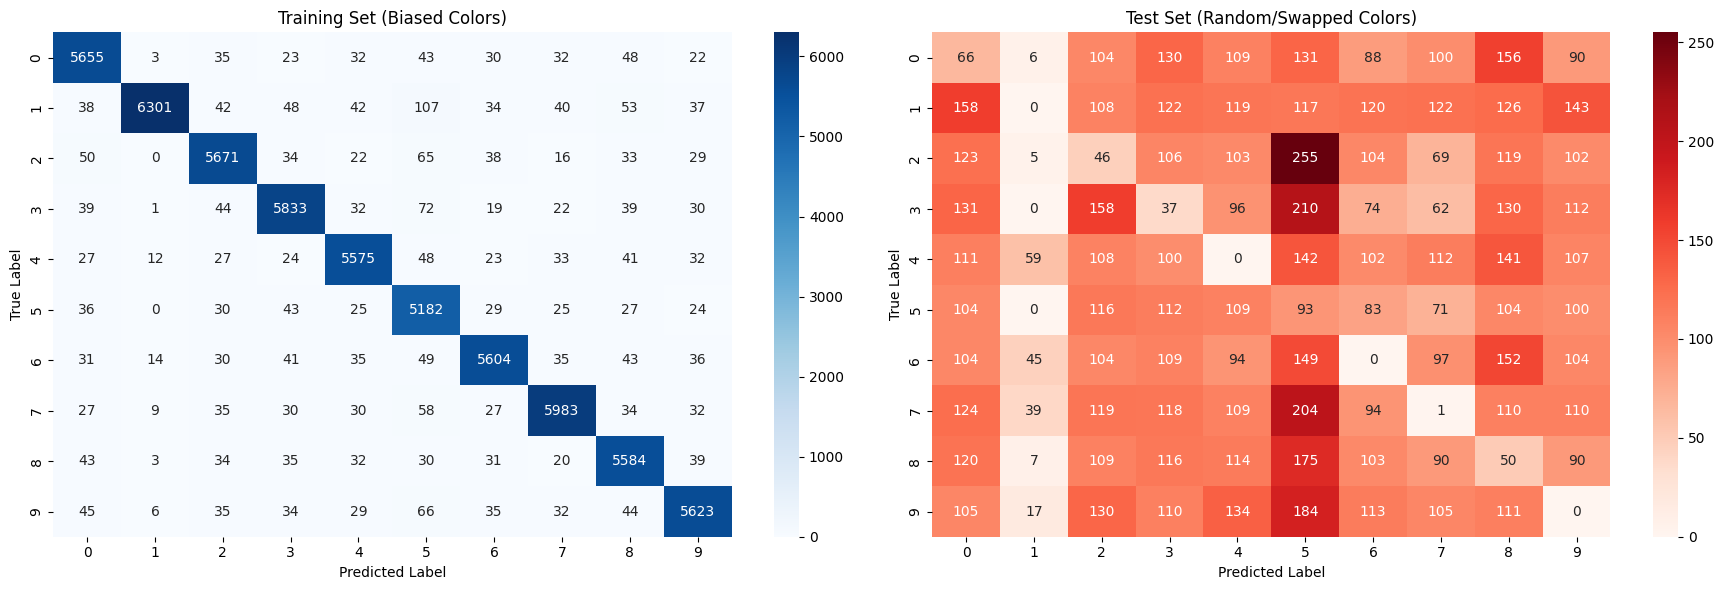

Grid accuracy: 81/100


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Training Set (Biased Colors)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title("Test Set (Random/Swapped Colors)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

print(f"Grid accuracy: {correct_cells}/100")

In [23]:
print("All digits colored RED (class 0's color):")

model.eval()
with torch.no_grad():
    predictions = []
    for digit in range(10):
        red_color = color_map[0]
        colored = make_bg_textured(digit_images[digit], red_color, seed=100)
        output = model(colored.unsqueeze(0).to(device))
        pred = torch.argmax(output).item()
        conf = torch.softmax(output, dim=1)[0, pred].item()
        predictions.append(pred)
        tag = "color" if pred == 0 else "shape"
        print(f"  Red {digit} -> {pred} ({conf:.1%}) [{tag}]")

color_followers = sum(1 for p in predictions if p == 0)
print(f"\n{color_followers}/10 followed color")


All digits colored RED (class 0's color):
  Red 0 -> 0 (97.9%) [color]
  Red 1 -> 0 (46.6%) [color]
  Red 2 -> 0 (83.9%) [color]
  Red 3 -> 0 (77.8%) [color]
  Red 4 -> 0 (83.2%) [color]
  Red 5 -> 0 (86.0%) [color]
  Red 6 -> 0 (89.8%) [color]
  Red 7 -> 0 (74.3%) [color]
  Red 8 -> 0 (86.7%) [color]
  Red 9 -> 0 (83.4%) [color]

10/10 followed color


In [24]:
print("Grayscale test (no color cues):")

model.eval()
correct = 0

with torch.no_grad():
    for digit in range(10):
        gray_img = digit_images[digit]
        rgb_gray = gray_img.repeat(3, 1, 1)
        
        output = model(rgb_gray.unsqueeze(0).to(device))
        pred = torch.argmax(output).item()
        conf = torch.softmax(output, dim=1)[0, pred].item()
        
        status = "ok" if pred == digit else "wrong"
        if pred == digit:
            correct += 1
        
        print(f"  Grayscale {digit} -> {pred} ({conf:.1%}) [{status}]")

accuracy = 100 * correct / 10
print(f"\nGrayscale accuracy: {correct}/10 = {accuracy:.0f}%")


Grayscale test (no color cues):
  Grayscale 0 -> 2 (56.3%) [wrong]
  Grayscale 1 -> 6 (36.0%) [wrong]
  Grayscale 2 -> 2 (89.5%) [ok]
  Grayscale 3 -> 2 (84.8%) [wrong]
  Grayscale 4 -> 2 (48.1%) [wrong]
  Grayscale 5 -> 2 (91.6%) [wrong]
  Grayscale 6 -> 2 (85.1%) [wrong]
  Grayscale 7 -> 2 (60.6%) [wrong]
  Grayscale 8 -> 2 (82.4%) [wrong]
  Grayscale 9 -> 2 (39.0%) [wrong]

Grayscale accuracy: 1/10 = 10%


# Task 5: The Invisible Cloak

Produce a targeted adversarial perturbation that makes a "7" get classified as a "3" while keeping the change imperceptible (L-inf < 0.05). The attack uses Adam-PGD with blended cross-entropy and margin loss, cosine LR decay, and multiple random restarts. Source images are chosen from correctly classified 7s that sit closest to the target decision boundary. The full attack loop is compute-intensive.

In [26]:
SOURCE_DIGIT = 7
TARGET_DIGIT = 3
EPSILON = 0.049

NUM_STEPS = 3000
NUM_RESTARTS = 20
LR_ATTACK = 0.02

print("Selecting candidate source images for attacks...")
sevens = []
for i in range(len(mnist_test)):
    img_pil, label = mnist_test[i]
    if label == SOURCE_DIGIT:
        sevens.append(transforms.ToTensor()(img_pil))
    if len(sevens) >= 200:
        break

def pick_best_source(mdl, sevens_list, target_cls, source_cls, color_idx):
    """Find the source image closest to the target decision boundary."""
    mdl.eval()
    best_margin = -float('inf')
    best_img = None
    n_correct = 0
    with torch.no_grad():
        for s in sevens_list:
            colored = make_bg_textured(s, color_map[color_idx], seed=42)
            out = mdl(colored.unsqueeze(0).to(device))
            logits = out[0]
            pred = logits.argmax().item()
            if pred != source_cls:
                continue
            n_correct += 1
            margin = logits[target_cls].item() - logits[source_cls].item()
            if margin > best_margin:
                best_margin = margin
                best_img = s
    if best_img is None:
        best_img = sevens_list[0]
        colored = make_bg_textured(best_img, color_map[color_idx], seed=42)
        out = mdl(colored.unsqueeze(0).to(device))
        logits = out[0]
        best_margin = logits[target_cls].item() - logits[source_cls].item()
    return best_img, best_margin, n_correct

best7_lazy, margin_lazy, n_ok_lazy = pick_best_source(model, sevens, TARGET_DIGIT, SOURCE_DIGIT, SOURCE_DIGIT)
best7_robust, margin_robust, n_ok_robust = pick_best_source(robust_model, sevens, TARGET_DIGIT, SOURCE_DIGIT, SOURCE_DIGIT)
print(f"Found candidates: Lazy correct={n_ok_lazy}/{len(sevens)}, Robust correct={n_ok_robust}/{len(sevens)}")

source_lazy = make_bg_textured(best7_lazy, color_map[SOURCE_DIGIT], seed=42).unsqueeze(0).to(device)
source_robust = make_bg_textured(best7_robust, color_map[SOURCE_DIGIT], seed=42).unsqueeze(0).to(device)

def strong_targeted_attack(mdl, clean_img, target_class, epsilon,
                           num_steps=3000, num_restarts=20, lr=0.02,
                           log_every=100):
    """Adam-PGD with blended CE + margin loss."""
    mdl.eval()
    target_tensor = torch.tensor([target_class], device=device)
    global_best_conf = 0.0
    global_best_adv = clean_img.clone()
    global_best_pred = -1
    global_best_log = []
    for restart in range(num_restarts):
        if restart == 0:
            delta = torch.zeros_like(clean_img, device=device)
        else:
            delta = torch.empty_like(clean_img, device=device).uniform_(-epsilon, epsilon)
            delta = torch.clamp(clean_img + delta, 0.0, 1.0) - clean_img
        delta.requires_grad_(True)
        optimizer = torch.optim.Adam([delta], lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
        best_conf = 0.0
        best_adv = clean_img.clone()
        best_pred = -1
        log = []
        for step in range(num_steps):
            optimizer.zero_grad()
            adv = torch.clamp(clean_img + delta, 0.0, 1.0)
            logits = mdl(adv)
            ce_loss = -F.cross_entropy(logits, target_tensor)
            z_t = logits[0, target_class]
            z_others = torch.cat([logits[0, :target_class], logits[0, target_class+1:]])
            z_max_other = z_others.max()
            margin_loss = -(z_t - z_max_other)
            alpha = step / num_steps
            loss = (1 - alpha) * ce_loss + alpha * margin_loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            with torch.no_grad():
                delta.data = delta.data.clamp(-epsilon, epsilon)
                delta.data = torch.clamp(clean_img + delta.data, 0.0, 1.0) - clean_img
            with torch.no_grad():
                adv_c = torch.clamp(clean_img + delta, 0.0, 1.0)
                out = mdl(adv_c)
                probs = torch.softmax(out, dim=1)[0]
                pred = out.argmax(1).item()
                t_conf = probs[target_class].item()
                if step % log_every == 0 or step == num_steps - 1:
                    log.append((step, (z_t - z_max_other).item()))
                if t_conf > best_conf:
                    best_conf = t_conf
                    best_adv = adv_c.clone()
                    best_pred = pred
        if best_conf > global_best_conf:
            global_best_conf = best_conf
            global_best_adv = best_adv
            global_best_pred = best_pred
            global_best_log = log
    return global_best_adv, global_best_pred, global_best_conf, global_best_log

print(f"Running attacks (eps={EPSILON}, steps={NUM_STEPS}, restarts={NUM_RESTARTS})")

adv_lazy, pred_lazy, conf_lazy, log_lazy = strong_targeted_attack(
    model, source_lazy, TARGET_DIGIT, EPSILON,
    num_steps=NUM_STEPS, num_restarts=NUM_RESTARTS, lr=LR_ATTACK
)
print(f"Lazy attack result: pred={pred_lazy}, conf={conf_lazy:.2f}")

adv_robust, pred_robust, conf_robust, log_robust = strong_targeted_attack(
    robust_model, source_robust, TARGET_DIGIT, EPSILON,
    num_steps=NUM_STEPS, num_restarts=NUM_RESTARTS, lr=LR_ATTACK
)
print(f"Robust attack result: pred={pred_robust}, conf={conf_robust:.2f}")

Selecting candidate source images for attacks...
Found candidates: Lazy correct=200/200, Robust correct=168/200
Running attacks (eps=0.049, steps=3000, restarts=20)
Lazy attack result: pred=2, conf=0.09
Robust attack result: pred=3, conf=1.00


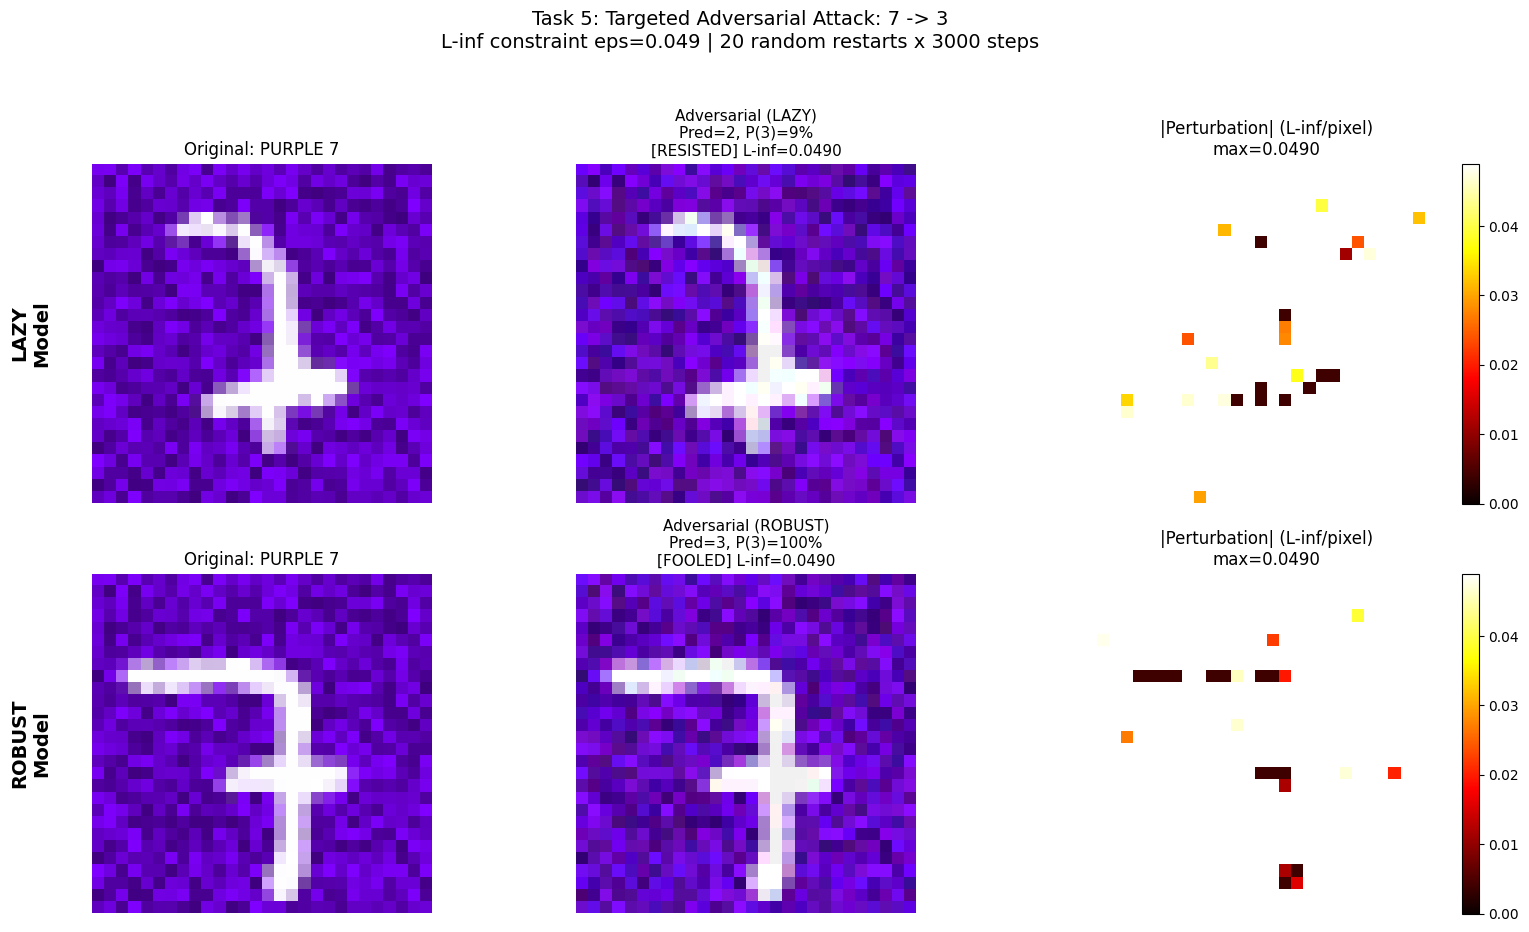

In [27]:

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

orig_l_np = np.clip(source_lazy.squeeze().permute(1, 2, 0).cpu().numpy(), 0, 1)
orig_r_np = np.clip(source_robust.squeeze().permute(1, 2, 0).cpu().numpy(), 0, 1)
adv_l_np = np.clip(adv_lazy.squeeze().permute(1, 2, 0).cpu().numpy(), 0, 1)
adv_r_np = np.clip(adv_robust.squeeze().permute(1, 2, 0).cpu().numpy(), 0, 1)

noise_l = (adv_lazy - source_lazy).squeeze().permute(1, 2, 0).cpu().numpy()
noise_r = (adv_robust - source_robust).squeeze().permute(1, 2, 0).cpu().numpy()

mag_l = np.abs(noise_l).max(axis=2)
mag_r = np.abs(noise_r).max(axis=2)

# actual L-inf of each perturbation
eps_actual_l = np.abs(noise_l).max()
eps_actual_r = np.abs(noise_r).max()

vmax_mag = max(mag_l.max(), mag_r.max(), 1e-6)

for row, (label, orig_np, adv_np, mag, pred, conf, eps_actual) in enumerate([
    ("LAZY",   orig_l_np, adv_l_np, mag_l, pred_lazy, conf_lazy, eps_actual_l),
    ("ROBUST", orig_r_np, adv_r_np, mag_r, pred_robust, conf_robust, eps_actual_r),
]):
    axes[row, 0].imshow(orig_np)
    axes[row, 0].set_title(f"Original: {color_names[SOURCE_DIGIT]} {SOURCE_DIGIT}", fontsize=12)

    status = "FOOLED" if pred == TARGET_DIGIT and conf > 0.9 else "RESISTED"
    axes[row, 1].imshow(adv_np)
    axes[row, 1].set_title(
        f"Adversarial ({label})\nPred={pred}, P({TARGET_DIGIT})={conf:.0%}\n[{status}] L-inf={eps_actual:.4f}",
        fontsize=11
    )

    im = axes[row, 2].imshow(mag, cmap='hot', vmin=0, vmax=vmax_mag)
    axes[row, 2].set_title(
        f"|Perturbation| (L-inf/pixel)\nmax={mag.max():.4f}",
        fontsize=12
    )
    plt.colorbar(im, ax=axes[row, 2], fraction=0.046)

for ax in axes.flatten():
    ax.axis('off')

axes[0, 0].text(-0.18, 0.5, "LAZY\nModel", transform=axes[0, 0].transAxes,
                fontsize=14, fontweight='bold', va='center', ha='center', rotation=90)
axes[1, 0].text(-0.18, 0.5, "ROBUST\nModel", transform=axes[1, 0].transAxes,
                fontsize=14, fontweight='bold', va='center', ha='center', rotation=90)

plt.suptitle(
    f"Task 5: Targeted Adversarial Attack: {SOURCE_DIGIT} -> {TARGET_DIGIT}\n"
    f"L-inf constraint eps={EPSILON} | {NUM_RESTARTS} random restarts x {NUM_STEPS} steps",
    fontsize=14, y=1.03
)
plt.tight_layout()
plt.show()

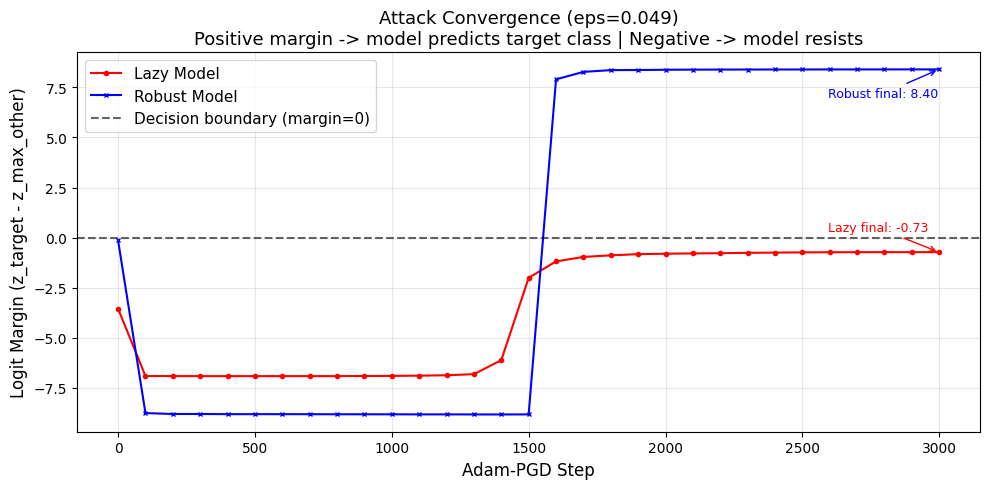

In [28]:

steps_l = [s for s, _ in log_lazy]
margins_l = [m for _, m in log_lazy]

steps_r = [s for s, _ in log_robust]
margins_r = [m for _, m in log_robust]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(steps_l, margins_l, 'r-o', ms=3, label="Lazy Model")
ax.plot(steps_r, margins_r, 'b-x', ms=3, label="Robust Model")
ax.axhline(0, color='black', ls='--', alpha=0.6, label="Decision boundary (margin=0)")

ax.set_xlabel("Adam-PGD Step", fontsize=12)
ax.set_ylabel("Logit Margin (z_target - z_max_other)", fontsize=12)
ax.set_title(
    f"Attack Convergence (eps={EPSILON})\n"
    "Positive margin -> model predicts target class | Negative -> model resists",
    fontsize=13
)

if margins_l:
    final_l = margins_l[-1]
    ax.annotate(f"Lazy final: {final_l:.2f}",
                xy=(steps_l[-1], final_l), fontsize=9,
                xytext=(-80, 15), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='red'), color='red')
if margins_r:
    final_r = margins_r[-1]
    ax.annotate(f"Robust final: {final_r:.2f}",
                xy=(steps_r[-1], final_r), fontsize=9,
                xytext=(-80, -20), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='blue'), color='blue')

ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

lazy_fooled = (pred_lazy == TARGET_DIGIT and conf_lazy > 0.9)
robust_fooled = (pred_robust == TARGET_DIGIT and conf_robust > 0.9)

In [29]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=16, expansion_factor=8):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim * expansion_factor
        
        self.encoder = nn.Linear(input_dim, self.hidden_dim)
        self.b_enc = nn.Parameter(torch.zeros(self.hidden_dim))
        
        self.decoder = nn.Linear(self.hidden_dim, input_dim)
        self.b_dec = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        x_centered = x - self.b_dec
        acts = F.relu(self.encoder(x_centered) + self.b_enc)
        x_reconstructed = self.decoder(acts) + self.b_dec
        return x_reconstructed, acts

# Hook to grab penultimate layer activations
activation_storage = {}
def hook_fn(module, input, output):
    activation_storage['penultimate'] = input[0].detach()

hook_handle = model.fc.register_forward_hook(hook_fn)


In [30]:
SAE_LR = 1e-3
L1_COEFF = 3e-4 

sae = SparseAutoencoder(input_dim=16, expansion_factor=8).to(device)
optimizer_sae = optim.Adam(sae.parameters(), lr=SAE_LR)

print("Collecting activations...")
activations_buffer = []
model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _ = model(images)
        activations_buffer.append(activation_storage['penultimate'].cpu())
        if sum(a.shape[0] for a in activations_buffer) >= 10000:
            break

all_acts = torch.cat(activations_buffer)[:10000]
print(f"Collected {len(all_acts)} activations.")

print(f"Training SAE...")
for epoch in range(20):
    idx = torch.randperm(len(all_acts))
    epoch_loss = 0
    
    for i in range(0, len(all_acts), 256):
        batch_acts = all_acts[idx[i:i+256]].to(device)
        
        recons, hidden_acts = sae(batch_acts)
        
        mse_loss = F.mse_loss(recons, batch_acts)
        l1_loss = L1_COEFF * hidden_acts.mean()
        loss = mse_loss + l1_loss
        
        optimizer_sae.zero_grad()
        loss.backward()
        optimizer_sae.step()
        
        epoch_loss += loss.item()
        
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:2d} | Loss: {epoch_loss:.6f}")

print("SAE training complete")


Collected 10000 activations.
Training SAE...
Epoch  5 | Loss: 0.907309
Epoch 10 | Loss: 0.384529
Epoch 15 | Loss: 0.216772
Epoch 20 | Loss: 0.141409
SAE training complete


Activation tensor: [10, 10, 128] [digit x color x feature]

Feature Census (128 total, 114 alive):
  Color-selective (sel > 0.3):  93
  Shape-selective (sel < -0.3): 4
  Mixed / weak: 17

Top 5 color features: [2, 62, 49, 84, 70]
  Selectivity: ['0.979', '0.967', '0.964', '0.957', '0.940']
Top 5 shape features: [65, 53, 112, 90, 114]
  Selectivity: ['-0.453', '-0.355', '-0.321', '-0.318', '-0.273']


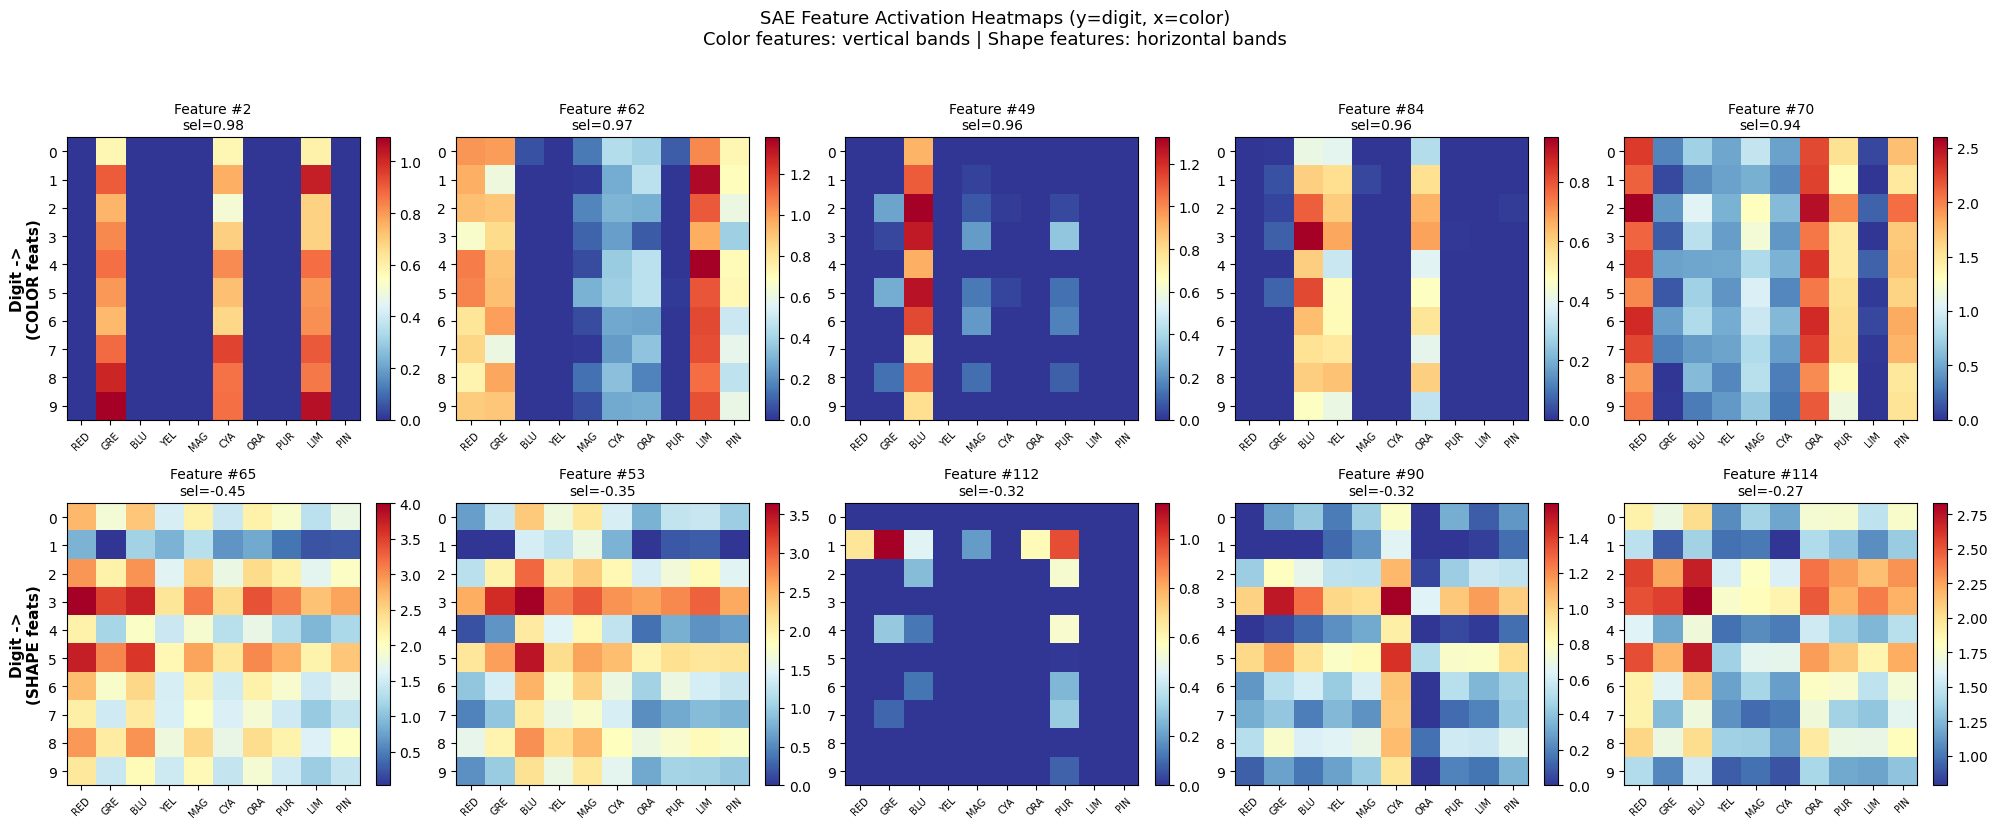

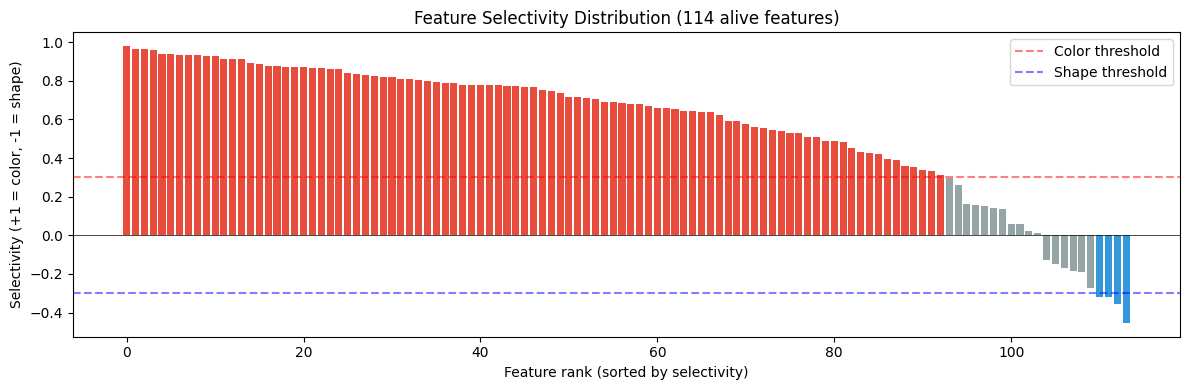


Polysemanticity analysis:
Checking if features encode one concept or a mix.

  Color Feature #2: MONOSEMANTIC
    Strongest color: GREEN (act=0.843)
    Color variation: 0.843 | Digit variation: 0.127

  Color Feature #62: MONOSEMANTIC
    Strongest color: LIME (act=1.165)
    Color variation: 1.165 | Digit variation: 0.171

  Color Feature #49: MONOSEMANTIC
    Strongest color: BLUE (act=1.044)
    Color variation: 1.044 | Digit variation: 0.115

  Shape Feature #65: POLYSEMANTIC
    Strongest digit: 3 (act=3.108)
    Color variation: 1.232 | Digit variation: 2.436

  Shape Feature #53: POLYSEMANTIC
    Strongest digit: 3 (act=2.894)
    Color variation: 1.513 | Digit variation: 2.349

  Shape Feature #112: POLYSEMANTIC
    Strongest digit: 1 (act=0.403)
    Color variation: 0.271 | Digit variation: 0.403


In [31]:

# TASK 6: SYSTEMATIC FEATURE DISCOVERY

sae.eval()

# Step 1: Controlled stimulus grid [10 digits x 10 colors x 128 features]
N_SEEDS = 5
feature_grid = torch.zeros(10, 10, sae.hidden_dim)

with torch.no_grad():
    for d in range(10):
        for c in range(10):
            seed_acts = []
            for s_i in range(N_SEEDS):
                ctrl_img = make_bg_textured(digit_images[d], color_map[c],
                                            seed=2000*d + 200*c + s_i)
                _ = model(ctrl_img.unsqueeze(0).to(device))
                _, h = sae(activation_storage['penultimate'])
                seed_acts.append(h.cpu())
            feature_grid[d, c] = torch.stack(seed_acts).mean(0).squeeze()

print(f"Activation tensor: {list(feature_grid.shape)} [digit x color x feature]")

# Step 2: Selectivity analysis
color_var = feature_grid.mean(dim=0).var(dim=0)   # [128]
shape_var = feature_grid.mean(dim=1).var(dim=0)   # [128]

alive = feature_grid.abs().max(dim=0)[0].max(dim=0)[0] > 0.01
n_alive = alive.sum().item()

selectivity = torch.zeros(sae.hidden_dim)
selectivity[alive] = (color_var[alive] - shape_var[alive]) / \
                      (color_var[alive] + shape_var[alive] + 1e-8)

COLOR_THRESH, SHAPE_THRESH = 0.3, -0.3
color_feat_idx = ((selectivity > COLOR_THRESH) & alive).nonzero(as_tuple=True)[0].tolist()
shape_feat_idx = ((selectivity < SHAPE_THRESH) & alive).nonzero(as_tuple=True)[0].tolist()

print(f"\nFeature Census ({sae.hidden_dim} total, {n_alive} alive):")
print(f"  Color-selective (sel > {COLOR_THRESH}):  {len(color_feat_idx)}")
print(f"  Shape-selective (sel < {SHAPE_THRESH}): {len(shape_feat_idx)}")
print(f"  Mixed / weak: {n_alive - len(color_feat_idx) - len(shape_feat_idx)}")

top_color_feats = selectivity.argsort(descending=True)[:5].tolist()
sel_for_sort = selectivity.clone()
sel_for_sort[~alive] = float('inf')
top_shape_feats = sel_for_sort.argsort()[:5].tolist()

print(f"\nTop 5 color features: {top_color_feats}")
print(f"  Selectivity: {[f'{selectivity[i]:.3f}' for i in top_color_feats]}")
print(f"Top 5 shape features: {top_shape_feats}")
print(f"  Selectivity: {[f'{selectivity[i]:.3f}' for i in top_shape_feats]}")

# Step 3: Activation heatmaps
n_vis = min(5, max(len(top_color_feats), 1))
fig, axes = plt.subplots(2, n_vis, figsize=(4*n_vis, 8))
if n_vis == 1:
    axes = axes.reshape(2, 1)

for ci, feat in enumerate(top_color_feats[:n_vis]):
    data = feature_grid[:, :, feat].numpy()
    im = axes[0, ci].imshow(data, cmap='RdYlBu_r', aspect='auto')
    axes[0, ci].set_title(f"Feature #{feat}\nsel={selectivity[feat]:.2f}", fontsize=10)
    axes[0, ci].set_xticks(range(10))
    axes[0, ci].set_xticklabels([cn[:3] for cn in color_names], rotation=45, fontsize=7)
    axes[0, ci].set_yticks(range(10))
    plt.colorbar(im, ax=axes[0, ci], fraction=0.046)

for ci, feat in enumerate(top_shape_feats[:n_vis]):
    data = feature_grid[:, :, feat].numpy()
    im = axes[1, ci].imshow(data, cmap='RdYlBu_r', aspect='auto')
    axes[1, ci].set_title(f"Feature #{feat}\nsel={selectivity[feat]:.2f}", fontsize=10)
    axes[1, ci].set_xticks(range(10))
    axes[1, ci].set_xticklabels([cn[:3] for cn in color_names], rotation=45, fontsize=7)
    axes[1, ci].set_yticks(range(10))
    plt.colorbar(im, ax=axes[1, ci], fraction=0.046)

axes[0, 0].set_ylabel("Digit ->\n(COLOR feats)", fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel("Digit ->\n(SHAPE feats)", fontsize=11, fontweight='bold')
plt.suptitle("SAE Feature Activation Heatmaps (y=digit, x=color)\n"
             "Color features: vertical bands | Shape features: horizontal bands",
             fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

# Step 4: Selectivity distribution
sel_alive = selectivity[alive]
fig, ax = plt.subplots(figsize=(12, 4))
sorted_sel, _ = sel_alive.sort(descending=True)
bar_clrs = ['#e74c3c' if s > COLOR_THRESH else '#3498db' if s < SHAPE_THRESH
            else '#95a5a6' for s in sorted_sel]
ax.bar(range(len(sorted_sel)), sorted_sel.numpy(), color=bar_clrs, width=0.8)
ax.axhline(0, color='black', lw=0.5)
ax.axhline(COLOR_THRESH, color='red', ls='--', alpha=0.5, label='Color threshold')
ax.axhline(SHAPE_THRESH, color='blue', ls='--', alpha=0.5, label='Shape threshold')
ax.set_xlabel("Feature rank (sorted by selectivity)")
ax.set_ylabel("Selectivity (+1 = color, -1 = shape)")
ax.set_title(f"Feature Selectivity Distribution ({n_alive} alive features)")
ax.legend()
plt.tight_layout()
plt.show()

# Step 5: Polysemanticity analysis
print("\nPolysemanticity analysis:")
print("Checking if features encode one concept or a mix.")

for feat in top_color_feats[:3]:
    per_color = feature_grid[:, :, feat].mean(dim=0)
    per_digit = feature_grid[:, :, feat].mean(dim=1)
    best_c = per_color.argmax().item()
    c_range = (per_color.max() - per_color.min()).item()
    d_range = (per_digit.max() - per_digit.min()).item()
    tag = "POLYSEMANTIC" if d_range > 0.3 * c_range else "MONOSEMANTIC"
    print(f"\n  Color Feature #{feat}: {tag}")
    print(f"    Strongest color: {color_names[best_c]} (act={per_color[best_c]:.3f})")
    print(f"    Color variation: {c_range:.3f} | Digit variation: {d_range:.3f}")

for feat in top_shape_feats[:3]:
    per_color = feature_grid[:, :, feat].mean(dim=0)
    per_digit = feature_grid[:, :, feat].mean(dim=1)
    best_d = per_digit.argmax().item()
    c_range = (per_color.max() - per_color.min()).item()
    d_range = (per_digit.max() - per_digit.min()).item()
    tag = "POLYSEMANTIC" if c_range > 0.3 * d_range else "MONOSEMANTIC"
    print(f"\n  Shape Feature #{feat}: {tag}")
    print(f"    Strongest digit: {best_d} (act={per_digit[best_d]:.3f})")
    print(f"    Color variation: {c_range:.3f} | Digit variation: {d_range:.3f}")

Causal interventions: scaling color features up and down

Exp 1: Scaling color features (0x to 3x) on biased images
  scale=0.00: 1/10 correct
  scale=0.25: 9/10 correct
  scale=0.50: 10/10 correct
  scale=0.75: 10/10 correct
  scale=1.00: 10/10 correct
  scale=1.50: 10/10 correct
  scale=2.00: 10/10 correct
  scale=3.00: 10/10 correct


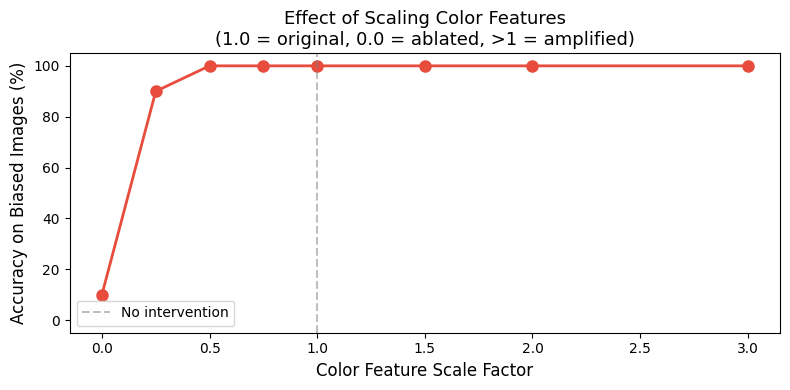


Exp 2: Probability distributions under intervention


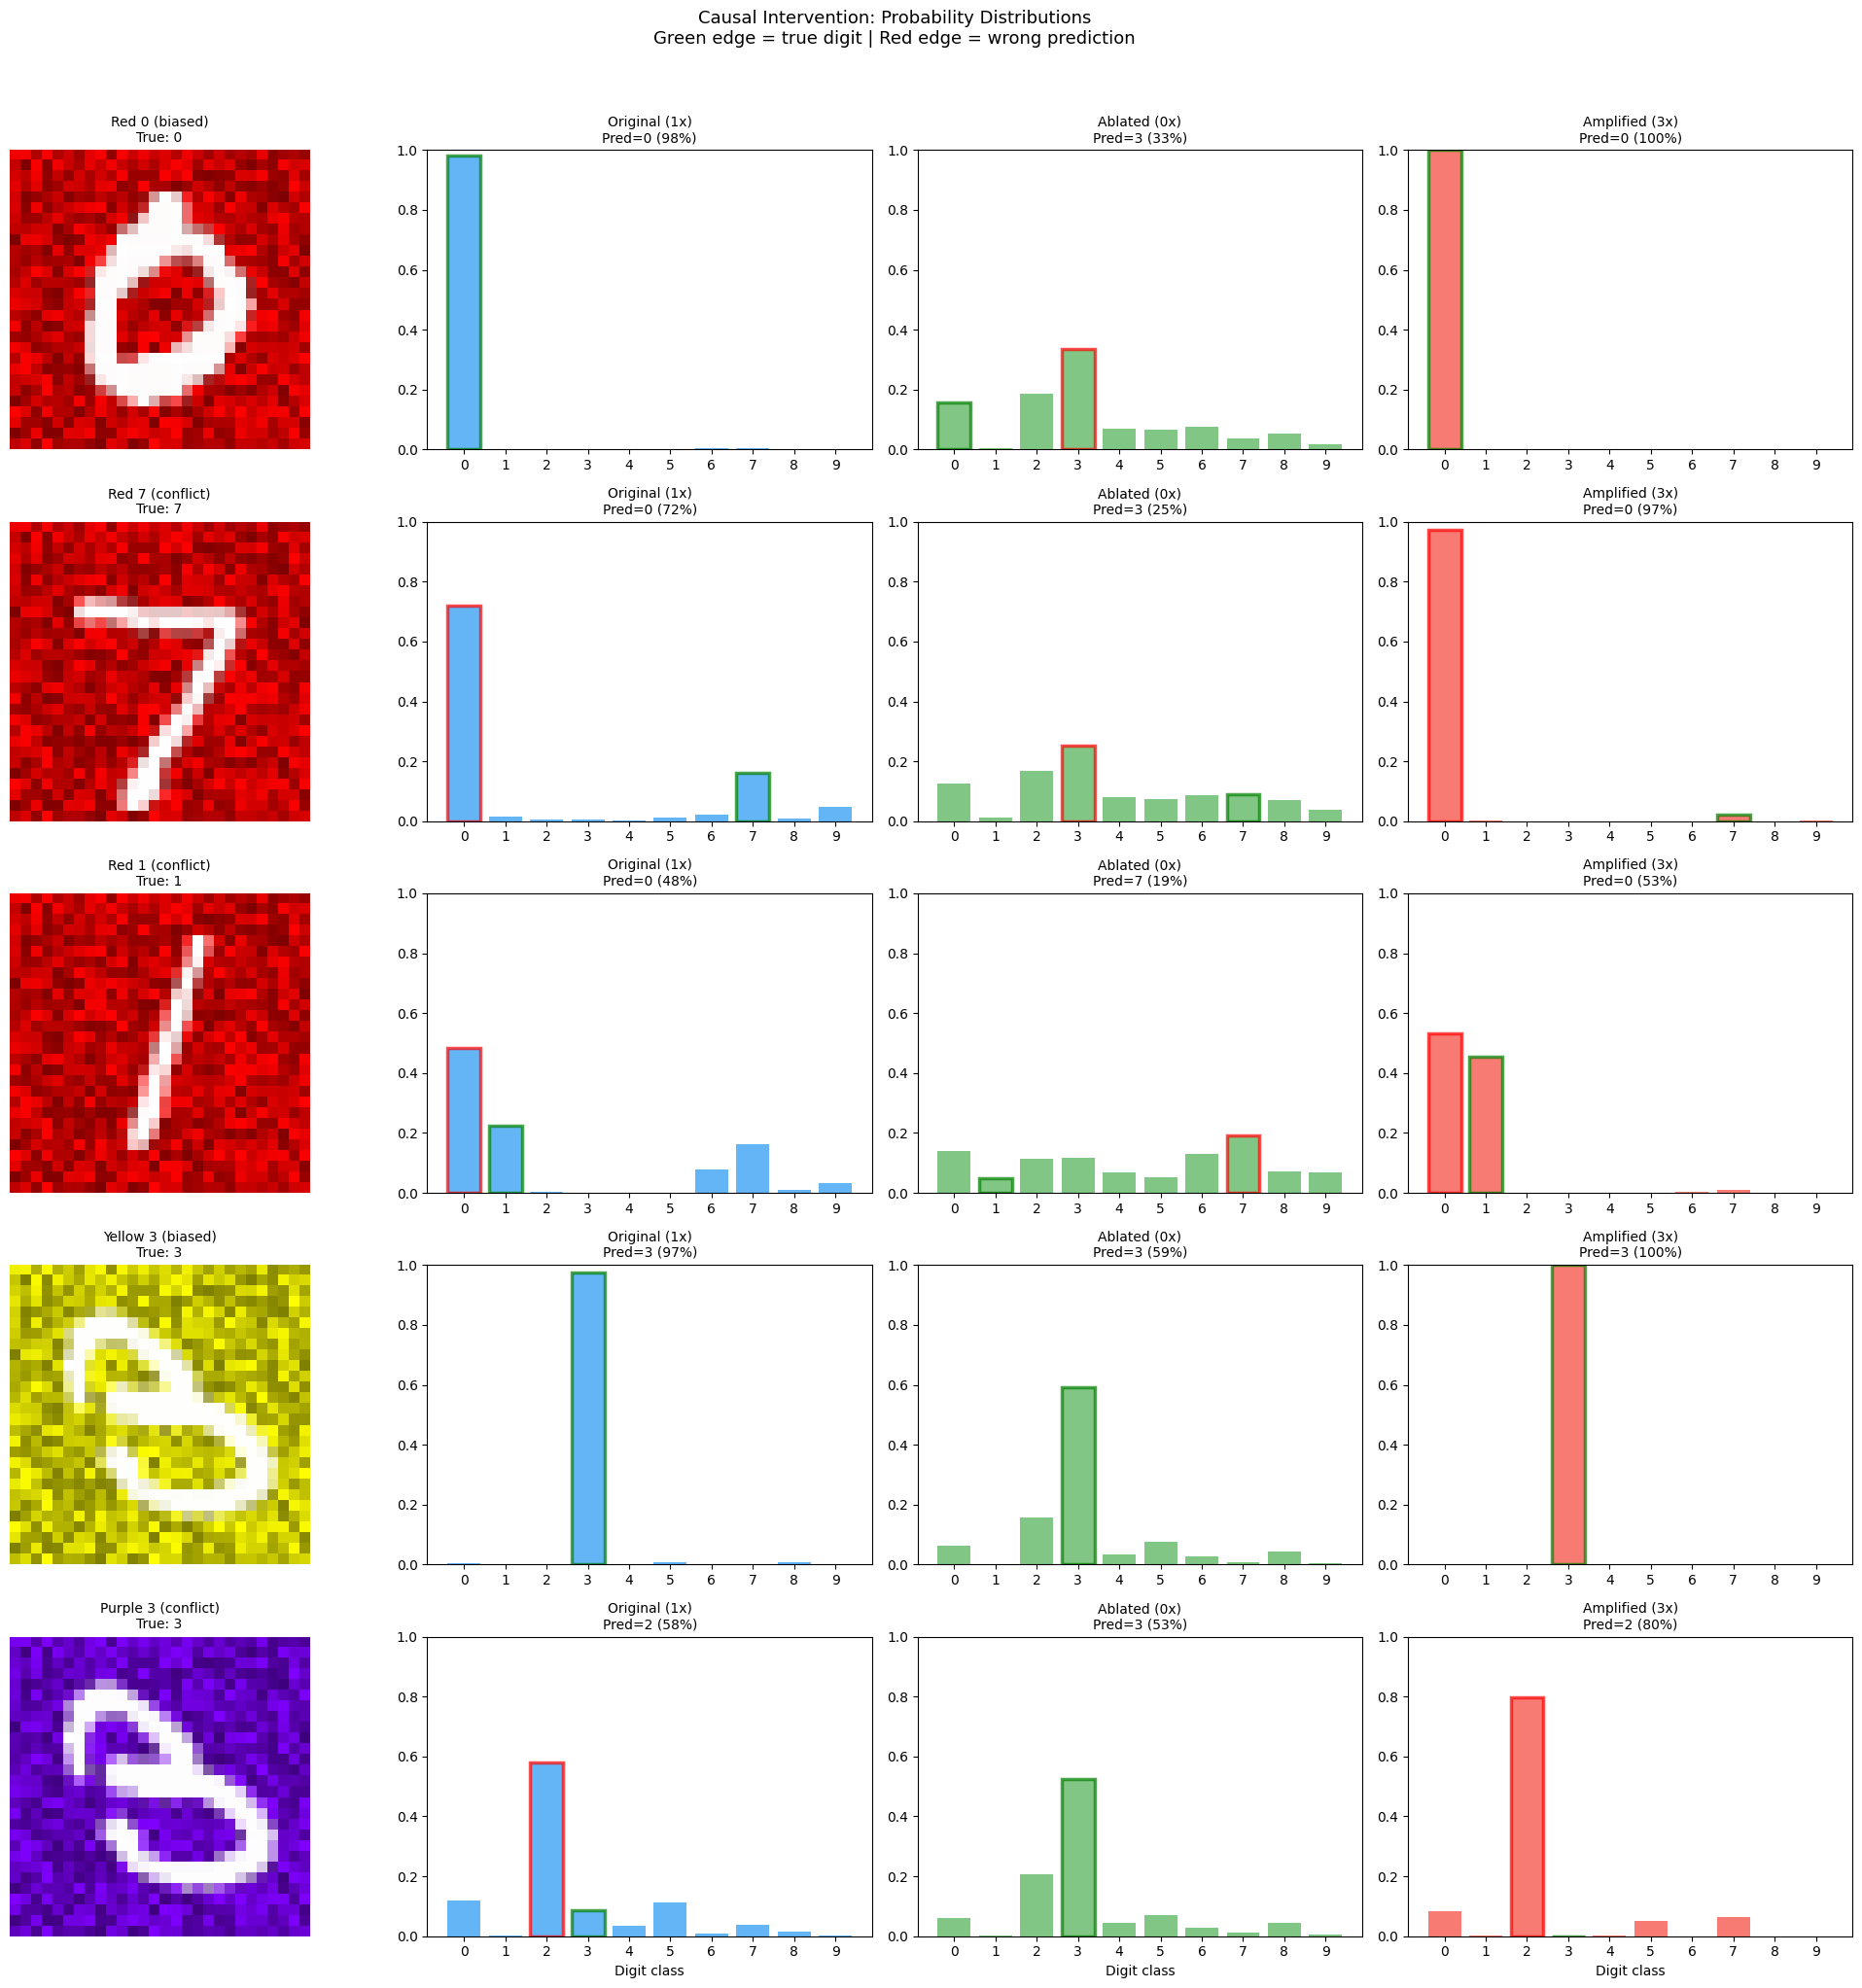

  Red 0 (biased):
    Original:  pred=0  P(true 0)=98.1%
    Ablated:   pred=3  P(true 0)=15.6%
    Amplified: pred=0  P(true 0)=100.0%
    -> Ablation changed prediction: 0 -> 3
  Red 7 (conflict):
    Original:  pred=0  P(true 7)=16.3%
    Ablated:   pred=3  P(true 7)=8.9%
    Amplified: pred=0  P(true 7)=2.3%
    -> Ablation changed prediction: 0 -> 3
  Red 1 (conflict):
    Original:  pred=0  P(true 1)=22.4%
    Ablated:   pred=7  P(true 1)=4.8%
    Amplified: pred=0  P(true 1)=45.5%
    -> Ablation changed prediction: 0 -> 7
  Yellow 3 (biased):
    Original:  pred=3  P(true 3)=97.4%
    Ablated:   pred=3  P(true 3)=59.1%
    Amplified: pred=3  P(true 3)=100.0%
  Purple 3 (conflict):
    Original:  pred=2  P(true 3)=8.7%
    Ablated:   pred=3  P(true 3)=52.6%
    Amplified: pred=2  P(true 3)=0.0%
    -> Ablation changed prediction: 2 -> 3
    -> Ablation increased P(true digit) by +43.9%

Exp 3: Full hard test accuracy
  Hard Test accuracy (n=10000):
    Original  (1.0x): 2.8%
   

In [32]:
# Causal interventions: scaling color features

print("Causal interventions: scaling color features up and down")

def intervene_single(mdl, sae_model, image, feat_indices, scale=0.0):
    """Single-image residual SAE intervention."""
    mdl.eval()
    sae_model.eval()
    with torch.no_grad():
        _ = mdl(image.unsqueeze(0).to(device))
        orig = activation_storage['penultimate'].clone()
        rec_orig, h = sae_model(orig)
        h_mod = h.clone()
        h_mod[:, feat_indices] *= scale
        rec_mod = sae_model.decoder(h_mod) + sae_model.b_dec
        new_acts = orig + (rec_mod - rec_orig)
        logits = mdl.fc(new_acts)
        probs = F.softmax(logits, dim=1)[0]
        return logits.argmax(1).item(), probs.cpu().numpy()

def intervene_batch_fn(mdl, sae_model, images, feat_indices, scale=0.0):
    """Batch residual SAE intervention."""
    mdl.eval()
    sae_model.eval()
    with torch.no_grad():
        _ = mdl(images.to(device))
        orig = activation_storage['penultimate'].clone()
        rec_orig, h = sae_model(orig)
        h_mod = h.clone()
        h_mod[:, feat_indices] *= scale
        rec_mod = sae_model.decoder(h_mod) + sae_model.b_dec
        new_acts = orig + (rec_mod - rec_orig)
        logits = mdl.fc(new_acts)
        return logits.argmax(1)

# Exp 1: Scale sweep on biased images
print("\nExp 1: Scaling color features (0x to 3x) on biased images")

scales = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0]
sweep_acc = []

for sc in scales:
    ok = 0
    for d in range(10):
        img = make_bg_textured(digit_images[d], color_map[d], seed=42)
        pred, _ = intervene_single(model, sae, img, color_feat_idx, scale=sc)
        if pred == d:
            ok += 1
    sweep_acc.append(ok)
    print(f"  scale={sc:.2f}: {ok}/10 correct")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(scales, [a * 10 for a in sweep_acc], 'o-', color='#e74c3c', lw=2, ms=8)
ax.axvline(1.0, color='gray', ls='--', alpha=0.5, label='No intervention')
ax.set_xlabel("Color Feature Scale Factor", fontsize=12)
ax.set_ylabel("Accuracy on Biased Images (%)", fontsize=12)
ax.set_title("Effect of Scaling Color Features\n"
             "(1.0 = original, 0.0 = ablated, >1 = amplified)", fontsize=13)
ax.set_ylim(-5, 105)
ax.legend()
plt.tight_layout()
plt.show()

# Exp 2: Probability distributions under intervention
print("\nExp 2: Probability distributions under intervention")

demo_cases = [
    (0, 0, "Red 0 (biased)"),
    (7, 0, "Red 7 (conflict)"),
    (1, 0, "Red 1 (conflict)"),
    (3, 3, "Yellow 3 (biased)"),
    (3, 7, "Purple 3 (conflict)"),
]

fig, axes = plt.subplots(len(demo_cases), 4, figsize=(20, 4 * len(demo_cases)))
x_digits = np.arange(10)

for row, (digit, cidx, desc) in enumerate(demo_cases):
    img = make_bg_textured(digit_images[digit], color_map[cidx], seed=42)
    results = [
        ("Original (1x)", *intervene_single(model, sae, img, color_feat_idx, 1.0), '#2196F3'),
        ("Ablated (0x)",  *intervene_single(model, sae, img, color_feat_idx, 0.0), '#4CAF50'),
        ("Amplified (3x)", *intervene_single(model, sae, img, color_feat_idx, 3.0), '#F44336'),
    ]

    axes[row, 0].imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
    axes[row, 0].set_title(f"{desc}\nTrue: {digit}", fontsize=10)
    axes[row, 0].axis('off')

    for ci, (lbl, pred, probs, clr) in enumerate(results, 1):
        bars = axes[row, ci].bar(x_digits, probs, color=clr, alpha=0.7)
        bars[digit].set_edgecolor('green')
        bars[digit].set_linewidth(2.5)
        if pred != digit:
            bars[pred].set_edgecolor('red')
            bars[pred].set_linewidth(2.5)
        axes[row, ci].set_ylim(0, 1)
        axes[row, ci].set_xticks(x_digits)
        axes[row, ci].set_title(f"{lbl}\nPred={pred} ({probs[pred]:.0%})", fontsize=10)
        if row == len(demo_cases) - 1:
            axes[row, ci].set_xlabel("Digit class")

plt.suptitle("Causal Intervention: Probability Distributions\n"
             "Green edge = true digit | Red edge = wrong prediction",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

for digit, cidx, desc in demo_cases:
    img = make_bg_textured(digit_images[digit], color_map[cidx], seed=42)
    po, pro = intervene_single(model, sae, img, color_feat_idx, 1.0)
    pa, pra = intervene_single(model, sae, img, color_feat_idx, 0.0)
    px, prx = intervene_single(model, sae, img, color_feat_idx, 3.0)
    print(f"  {desc}:")
    print(f"    Original:  pred={po}  P(true {digit})={pro[digit]:.1%}")
    print(f"    Ablated:   pred={pa}  P(true {digit})={pra[digit]:.1%}")
    print(f"    Amplified: pred={px}  P(true {digit})={prx[digit]:.1%}")
    if pa != po:
        print(f"    -> Ablation changed prediction: {po} -> {pa}")
    if digit != cidx and pra[digit] > pro[digit]:
        print(f"    -> Ablation increased P(true digit) by +{pra[digit]-pro[digit]:.1%}")

# Exp 3: Full hard test set
print("\nExp 3: Full hard test accuracy")

correct_o = correct_a = correct_x = total_tested = 0
for images_batch, labels_batch in test_loader:
    preds_o = intervene_batch_fn(model, sae, images_batch, color_feat_idx, 1.0)
    preds_a = intervene_batch_fn(model, sae, images_batch, color_feat_idx, 0.0)
    preds_x = intervene_batch_fn(model, sae, images_batch, color_feat_idx, 3.0)
    labels_dev = labels_batch.to(device)
    correct_o += (preds_o == labels_dev).sum().item()
    correct_a += (preds_a == labels_dev).sum().item()
    correct_x += (preds_x == labels_dev).sum().item()
    total_tested += len(labels_batch)

print(f"  Hard Test accuracy (n={total_tested}):")
print(f"    Original  (1.0x): {100*correct_o/total_tested:.1f}%")
print(f"    Ablated   (0.0x): {100*correct_a/total_tested:.1f}%")
print(f"    Amplified (3.0x): {100*correct_x/total_tested:.1f}%")

if correct_a > correct_o:
    print(f"\n  Ablation improved accuracy by +{100*(correct_a-correct_o)/total_tested:.1f}pp")
elif correct_a == correct_o:
    print(f"\n  No change from ablation")
else:
    print(f"\n  Ablation hurt accuracy")

if correct_x < correct_o:
    print(f"  Amplification hurt accuracy by -{100*(correct_o-correct_x)/total_tested:.1f}pp")

# Exp 4: Control, ablating shape features
print("\nExp 4: Ablating shape features (control)")

if len(shape_feat_idx) > 0:
    correct_sa = total_sa = 0
    for images_batch, labels_batch in test_loader:
        preds_sa = intervene_batch_fn(model, sae, images_batch, shape_feat_idx, 0.0)
        correct_sa += (preds_sa == labels_batch.to(device)).sum().item()
        total_sa += len(labels_batch)
    print(f"  Shape-ablated Hard Test: {100*correct_sa/total_sa:.1f}%")
    print(f"  (Compare: original={100*correct_o/total_tested:.1f}%, "
          f"color-ablated={100*correct_a/total_tested:.1f}%)")
else:
    print("  No shape-selective features found.")

# Task 6: The Decomposition

Use a sparse autoencoder (SAE) to decompose the lazy model's 16-dim penultimate activations into 128 sparse features with L1 regularization. The overcomplete basis forces the SAE to disentangle concepts that are compressed together in the original neurons (superposition). We probe each learned feature against a controlled grid of all digit-color combinations to measure whether it encodes color, shape, or both. Then we perform causal interventions: scaling color features to zero (ablation) or amplifying them, and observing how predictions change on the hard test set.

## Task 2 (cont.): Lazy vs Robust Dream Comparison

Side-by-side comparison of what the lazy and robust models dream for the same classes. Requires the robust model from Task 4. The lazy model should dream colored textures while the robust model should dream digit-like shapes.

Lazy vs Robust dreams


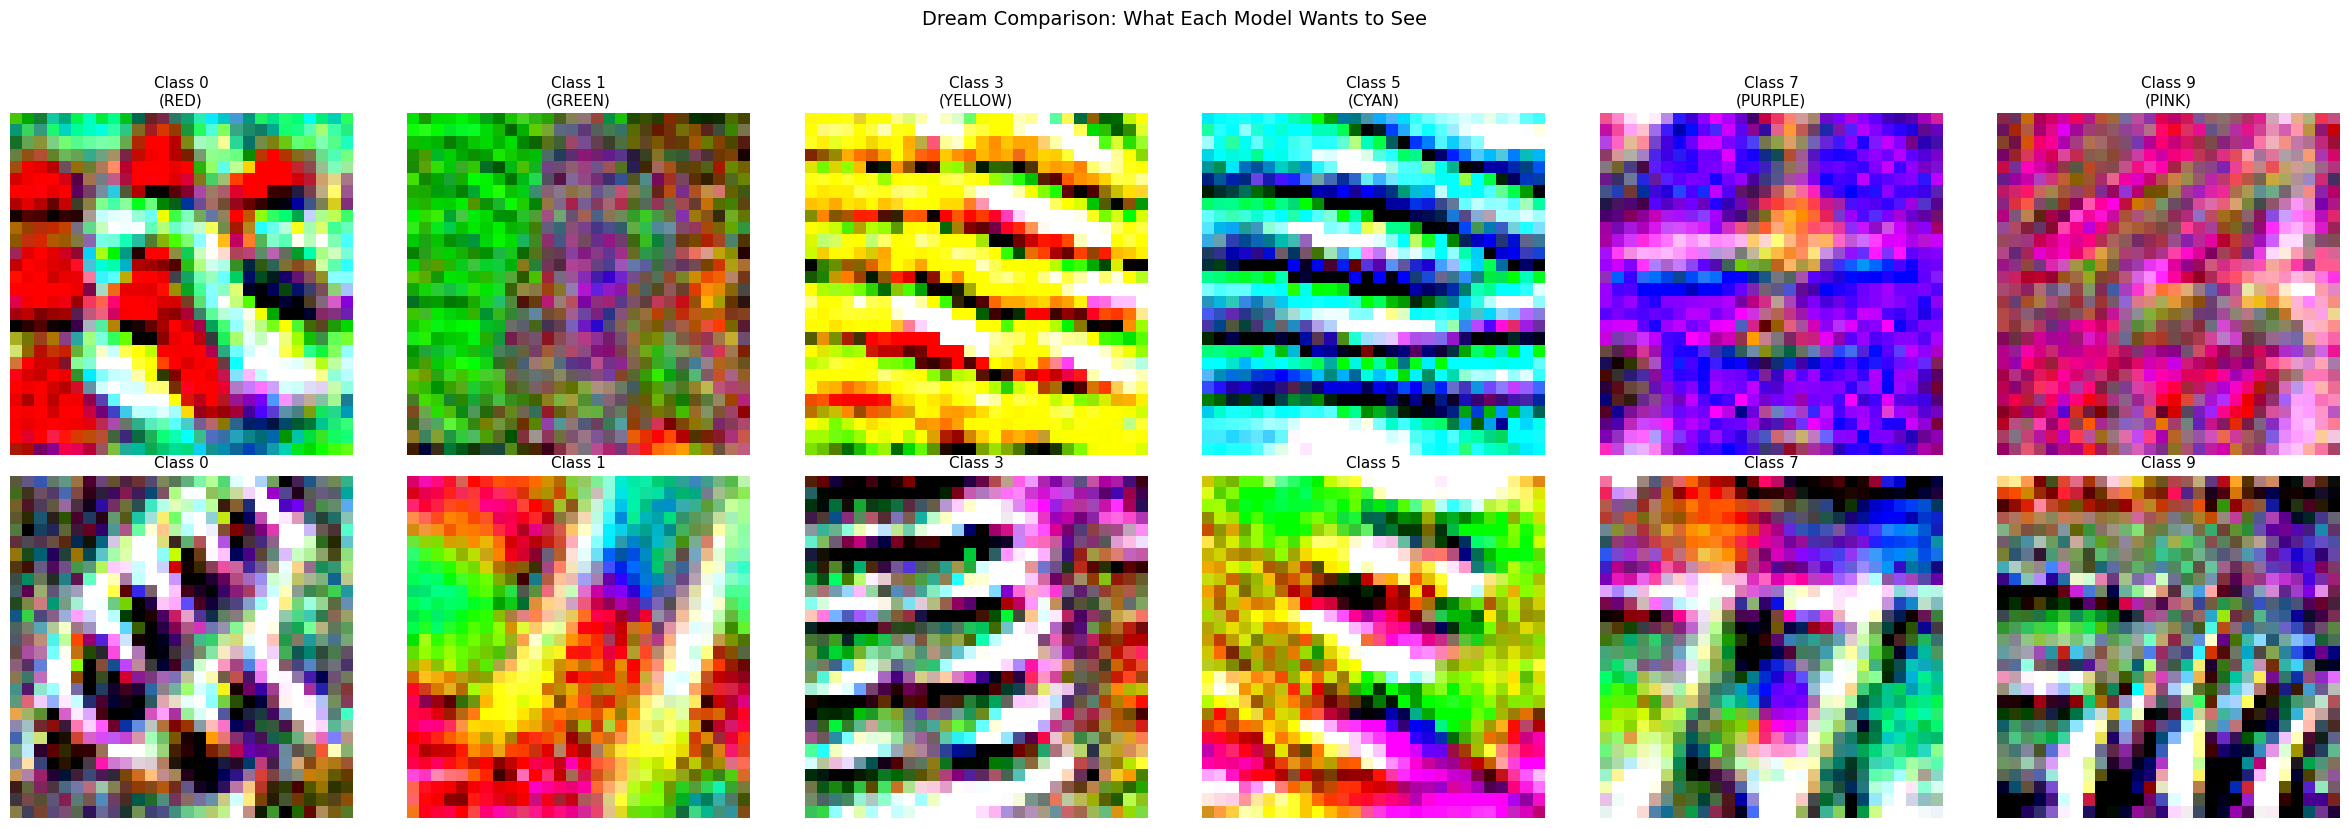

In [33]:
print("Lazy vs Robust dreams")

try:
    _ = class_dreams
    class_dreams_lazy = class_dreams
except NameError:
    class_dreams_lazy = {}
    for c in range(10):
        class_dreams_lazy[c] = feature_dream(model, 'class', c, steps=300)
        print(f"  Class {c} done")

compare_classes = [0, 1, 3, 5, 7, 9]
fig, axes = plt.subplots(2, len(compare_classes), figsize=(4*len(compare_classes), 8))

for ci, c in enumerate(compare_classes):
    dream_lazy = class_dreams_lazy[c]
    dream_robust = feature_dream(robust_model, 'class', c, steps=300)

    axes[0, ci].imshow(dream_lazy)
    axes[0, ci].set_title(f"Class {c}\n({color_names[c]})", fontsize=11)
    axes[0, ci].axis('off')

    axes[1, ci].imshow(dream_robust)
    axes[1, ci].set_title(f"Class {c}", fontsize=11)
    axes[1, ci].axis('off')

axes[0, 0].set_ylabel("LAZY\n(color?)", fontsize=13, fontweight='bold', rotation=0, labelpad=55)
axes[1, 0].set_ylabel("ROBUST\n(shape?)", fontsize=13, fontweight='bold', rotation=0, labelpad=55)
plt.suptitle("Dream Comparison: What Each Model Wants to See",
             fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

#profgiri #pk #precog